In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
import numpy as np
from matplotlib import pyplot
import pandas as pd
import matplotlib.pyplot as plt

from torchvision import datasets, transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device is", device)

device is cuda:0


In [2]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.act = nn.LeakyReLU(0.2)

        # input: 100      
        self.fc1 = nn.Linear(in_features=100, out_features=128)    
        self.fc2 = nn.Linear(in_features=128, out_features=512)    
        self.fc3 = nn.Linear(in_features=512, out_features=784)

        self.sig = nn.Sigmoid()


    
    def forward(self, x):
        x = self.fc1(x) #100->128
        x = self.act(x) #128->128
        x = self.fc2(x) #128->784
        x = self.act(x) #128->128
        x = self.fc3(x) #128->784
        x = self.sig(x) #784->784 (28x28)
        return x

class Generator_loss(nn.Module):
    def __init__(self):
        super(Generator_loss, self).__init__()

    def forward(self, output_fake):
        loss = -torch.log(output_fake)
        return loss.mean()
    
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.act = nn.ReLU()

        # input: 784     
        self.fc1 = nn.Linear(in_features=784, out_features=128) 
        self.fc2 = nn.Linear(in_features=128, out_features=1)

        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x) #784->128
        x = self.act(x) #128->128
        x_logits = self.fc2(x) #128->1
        x_prob = self.sig(x_logits) #1->1
        return x_prob, x_logits
    
class Discriminator_loss(nn.Module):
    def __init__(self):
        super(Discriminator_loss, self).__init__()

    def forward(self, output_real, output_fake):
        loss = -(torch.log(output_real)+torch.log(1-output_fake))
        return loss.mean()

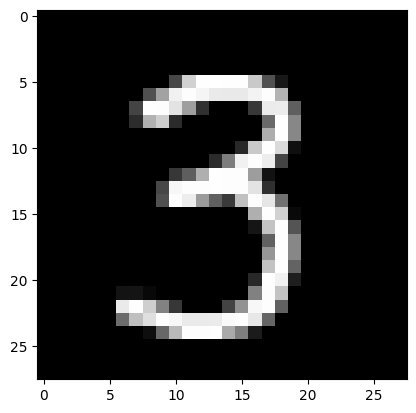

In [3]:
# Define the mini-batch size
batch_size = 100

# Download the dataset and create the dataloaders
mnist_train = datasets.MNIST("./", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("./", train=False, download=True, transform=transforms.ToTensor())

dataset = datasets.MNIST(root='./', transform=transforms.ToTensor())
#idx = dataset.train_labels==5
#dataset.targets = dataset.train_labels[idx]
#dataset.data = dataset.train_data[idx]

# Dataset is split 8:2
train_size = int(0.8 * len(mnist_train))
val_size = len(mnist_train) - train_size
mnist_train, mnist_val = random_split(mnist_train, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)
val_loader = torch.utils.data.DataLoader(mnist_val, batch_size=batch_size, shuffle=False)

to_onehot = nn.Embedding(10, 10)
to_onehot.weight.data = torch.eye(10)

def plot_digit(data):
    data = data.view(28, 28)
    plt.imshow(data, cmap="gray")

    plt.show()

images, labels = next(iter(train_loader))
plot_digit(images[0])

In [4]:
def train_models(model_d, criterion_d, optimizer_d, model_g, criterion_g, optimizer_g, epochs, train_loader, k, batch_sz):
    it = iter(train_loader)
    for epoch in range(epochs):
          
        #Train Discriminator 
        for batch_nr in range(k):
            try:
                images,_ = next(it)
            except:
                it = iter(train_loader)
                images,_ = next(it)          
            _, out_real = model_d(torch.flatten(images,start_dim=1).to(device))
            _, out_fake = model_d(model_g(torch.randn(out_real.shape[0],100).to(device)))
            optimizer_d.zero_grad()
            loss_d_real = criterion_d(out_real,torch.ones_like(out_real)).to(device)
            loss_d_fake = criterion_d(out_fake,torch.zeros_like(out_fake)).to(device)
            loss_d = loss_d_real+loss_d_fake
            loss_d.backward()
            optimizer_d.step()

        #Train Generator
        _, out_fake = model_d(model_g(torch.randn(batch_sz,100).to(device)))
        optimizer_g.zero_grad()
        loss_g = criterion_g(out_fake,torch.ones_like(out_fake)).to(device)
        loss_g.backward()
        optimizer_g.step()
        
        
        
        if epoch%50==0:
            print("Epoch:",epoch)  
            print("loss_g:",loss_g.item(),"\tloss_d:",loss_d.item())
        if epoch%500==0:
            noise = torch.randn(batch_sz,100)
            disp = model_g(noise.to(device))
            plot_digit(torch.reshape(disp[0,:],(28,28)).detach().cpu())
            plot_digit(torch.reshape(disp[1,:],(28,28)).detach().cpu())
            plot_digit(torch.reshape(disp[2,:],(28,28)).detach().cpu())

Epoch: 0
loss_g: 0.7788331508636475 	loss_d: 1.4283921718597412


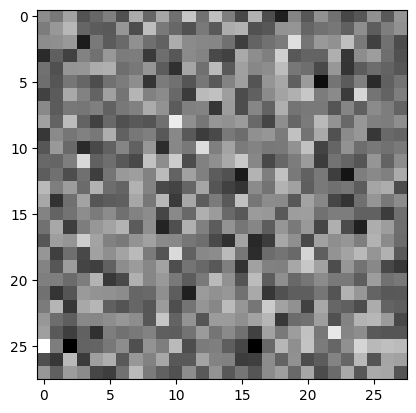

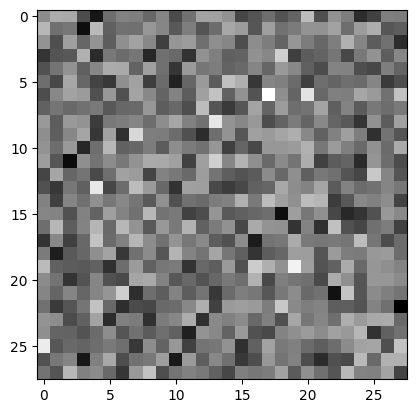

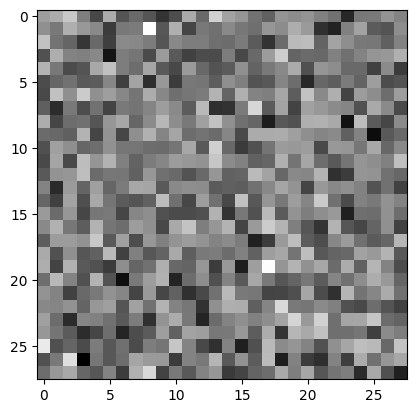

Epoch: 50
loss_g: 1.6869280338287354 	loss_d: 0.5604969263076782
Epoch: 100
loss_g: 1.3783080577850342 	loss_d: 1.0646204948425293
Epoch: 150
loss_g: 1.2010825872421265 	loss_d: 1.1932839155197144
Epoch: 200
loss_g: 1.4122965335845947 	loss_d: 0.9291692972183228
Epoch: 250
loss_g: 1.647892713546753 	loss_d: 0.65301513671875
Epoch: 300
loss_g: 1.8341141939163208 	loss_d: 0.587752640247345
Epoch: 350
loss_g: 2.043374538421631 	loss_d: 0.5399284958839417
Epoch: 400
loss_g: 1.63331139087677 	loss_d: 0.9828627705574036
Epoch: 450
loss_g: 1.367544174194336 	loss_d: 1.1281499862670898
Epoch: 500
loss_g: 0.6759011745452881 	loss_d: 1.890770435333252


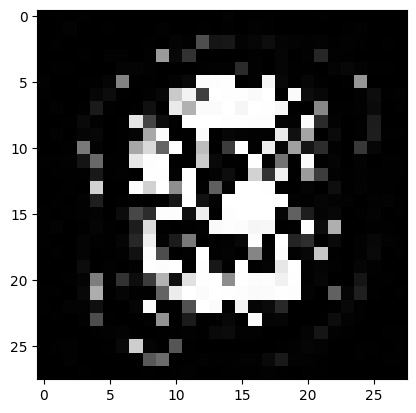

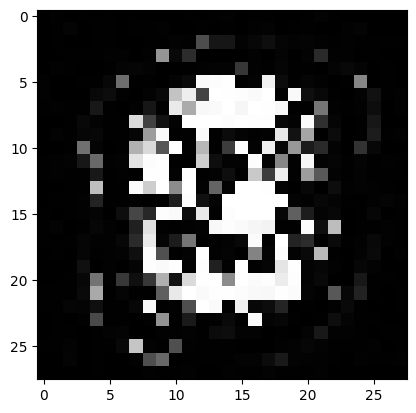

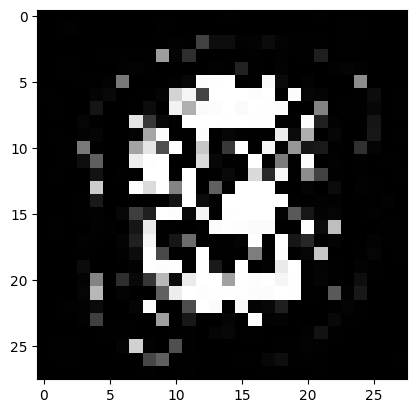

Epoch: 550
loss_g: 0.8754258751869202 	loss_d: 1.957242727279663
Epoch: 600
loss_g: 1.712606430053711 	loss_d: 0.8800049424171448
Epoch: 650
loss_g: 1.8549447059631348 	loss_d: 0.6266482472419739
Epoch: 700
loss_g: 0.8413503766059875 	loss_d: 2.218928337097168
Epoch: 750
loss_g: 1.0536891222000122 	loss_d: 1.5078738927841187
Epoch: 800
loss_g: 1.4168646335601807 	loss_d: 0.973814845085144
Epoch: 850
loss_g: 1.6449673175811768 	loss_d: 0.5816447734832764
Epoch: 900
loss_g: 1.7490721940994263 	loss_d: 0.6583619713783264
Epoch: 950
loss_g: 1.9416213035583496 	loss_d: 0.4922540783882141
Epoch: 1000
loss_g: 2.239752769470215 	loss_d: 0.327552855014801


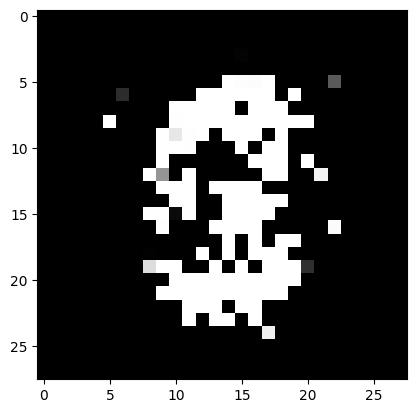

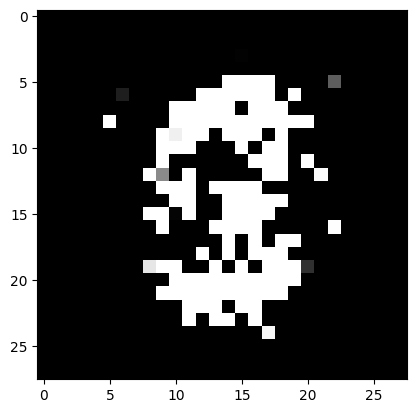

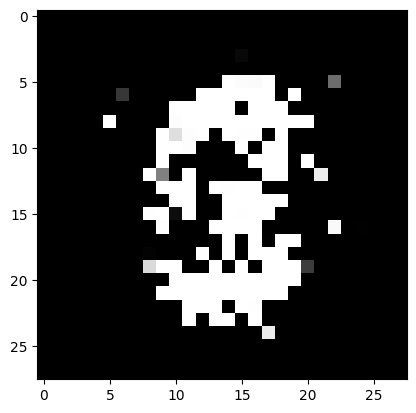

Epoch: 1050
loss_g: 2.2941153049468994 	loss_d: 0.26549193263053894
Epoch: 1100
loss_g: 2.1531388759613037 	loss_d: 0.3998296856880188
Epoch: 1150
loss_g: 0.9381752014160156 	loss_d: 1.135183572769165
Epoch: 1200
loss_g: 0.620602548122406 	loss_d: 2.307281732559204
Epoch: 1250
loss_g: 1.1020894050598145 	loss_d: 1.2858073711395264
Epoch: 1300
loss_g: 2.0562210083007812 	loss_d: 0.6305471062660217
Epoch: 1350
loss_g: 1.9681529998779297 	loss_d: 0.575029194355011
Epoch: 1400
loss_g: 2.0300488471984863 	loss_d: 0.6340145468711853
Epoch: 1450
loss_g: 1.2510325908660889 	loss_d: 1.4711575508117676
Epoch: 1500
loss_g: 1.940636396408081 	loss_d: 0.46883153915405273


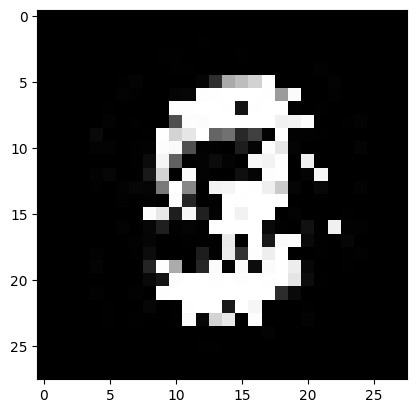

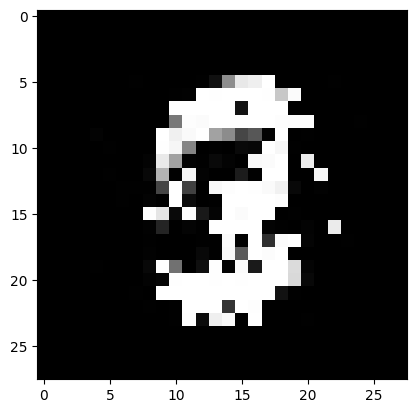

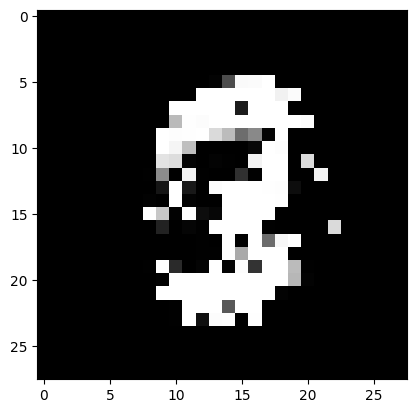

Epoch: 1550
loss_g: 2.306419610977173 	loss_d: 0.2764419913291931
Epoch: 1600
loss_g: 2.447798490524292 	loss_d: 0.21727275848388672
Epoch: 1650
loss_g: 1.561614990234375 	loss_d: 0.5263135433197021
Epoch: 1700
loss_g: 1.4295926094055176 	loss_d: 0.9416761994361877
Epoch: 1750
loss_g: 2.235243797302246 	loss_d: 0.37161099910736084
Epoch: 1800
loss_g: 2.5156021118164062 	loss_d: 0.28123193979263306
Epoch: 1850
loss_g: 1.89577317237854 	loss_d: 0.6252573728561401
Epoch: 1900
loss_g: 1.7921507358551025 	loss_d: 0.6499578356742859
Epoch: 1950
loss_g: 2.053402900695801 	loss_d: 0.4368492662906647
Epoch: 2000
loss_g: 1.7244319915771484 	loss_d: 0.4947487711906433


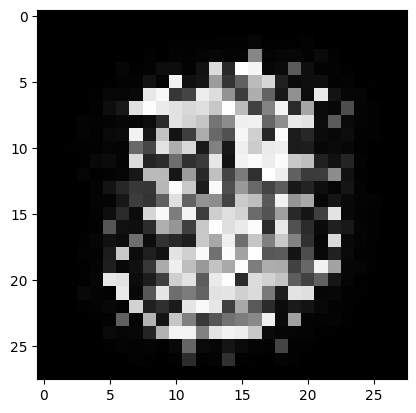

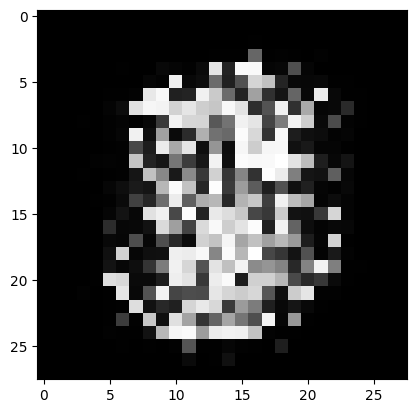

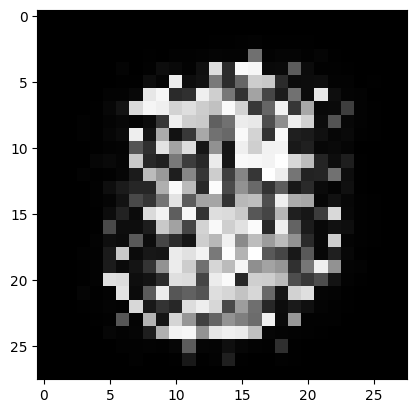

Epoch: 2050
loss_g: 1.2478890419006348 	loss_d: 1.2700061798095703
Epoch: 2100
loss_g: 1.2261121273040771 	loss_d: 1.1291344165802002
Epoch: 2150
loss_g: 1.7149478197097778 	loss_d: 0.4644721448421478
Epoch: 2200
loss_g: 1.5255314111709595 	loss_d: 0.6612075567245483
Epoch: 2250
loss_g: 1.196933627128601 	loss_d: 1.2855455875396729
Epoch: 2300
loss_g: 1.9984447956085205 	loss_d: 0.41789931058883667
Epoch: 2350
loss_g: 1.688167691230774 	loss_d: 0.6154043078422546
Epoch: 2400
loss_g: 1.807922124862671 	loss_d: 0.7247918844223022
Epoch: 2450
loss_g: 1.848545789718628 	loss_d: 0.8533308506011963
Epoch: 2500
loss_g: 1.64633047580719 	loss_d: 0.883782148361206


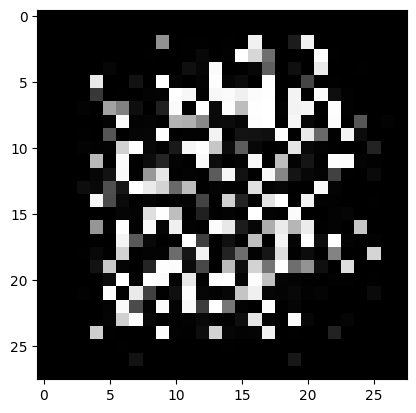

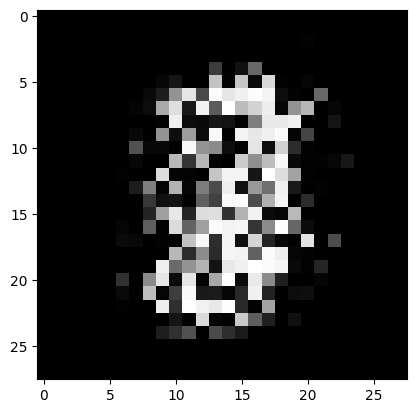

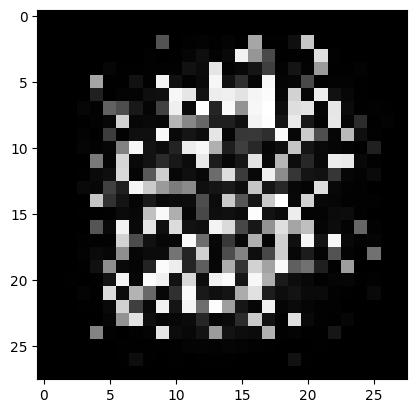

Epoch: 2550
loss_g: 1.6386187076568604 	loss_d: 0.6751146912574768
Epoch: 2600
loss_g: 1.547597885131836 	loss_d: 0.9162606000900269
Epoch: 2650
loss_g: 1.3739299774169922 	loss_d: 0.9656730890274048
Epoch: 2700
loss_g: 1.213355541229248 	loss_d: 0.8064053058624268
Epoch: 2750
loss_g: 1.3164745569229126 	loss_d: 0.6028001308441162
Epoch: 2800
loss_g: 0.9193038940429688 	loss_d: 0.9302948713302612
Epoch: 2850
loss_g: 0.7892467975616455 	loss_d: 0.9635758996009827
Epoch: 2900
loss_g: 0.7556547522544861 	loss_d: 1.0014405250549316
Epoch: 2950
loss_g: 0.8003992438316345 	loss_d: 0.8532927632331848
Epoch: 3000
loss_g: 0.8745782971382141 	loss_d: 0.8045743107795715


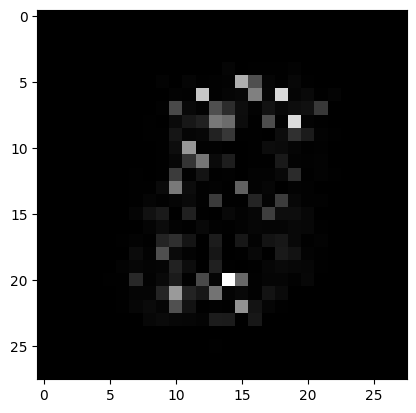

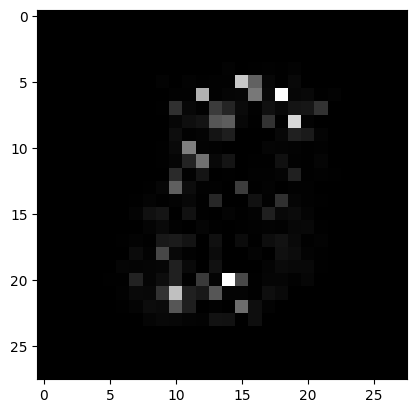

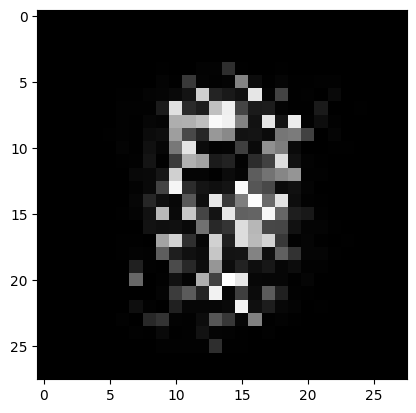

Epoch: 3050
loss_g: 0.7620013952255249 	loss_d: 0.9792340993881226
Epoch: 3100
loss_g: 0.8532200455665588 	loss_d: 0.8698270320892334
Epoch: 3150
loss_g: 0.8943880796432495 	loss_d: 0.7532420754432678
Epoch: 3200
loss_g: 0.7702232003211975 	loss_d: 0.8589344024658203
Epoch: 3250
loss_g: 0.9589043855667114 	loss_d: 0.7782312035560608
Epoch: 3300
loss_g: 0.8694769740104675 	loss_d: 0.834092378616333
Epoch: 3350
loss_g: 0.7581465244293213 	loss_d: 0.8850390911102295
Epoch: 3400
loss_g: 0.9470574259757996 	loss_d: 0.7507023215293884
Epoch: 3450
loss_g: 1.0295547246932983 	loss_d: 0.738021194934845
Epoch: 3500
loss_g: 1.2334030866622925 	loss_d: 0.7369718551635742


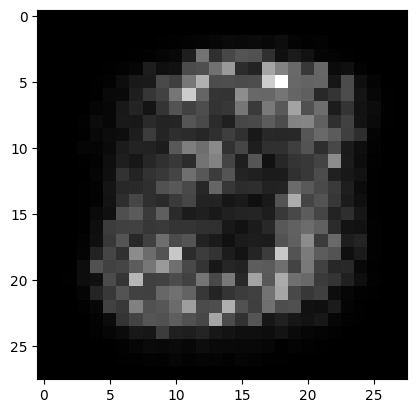

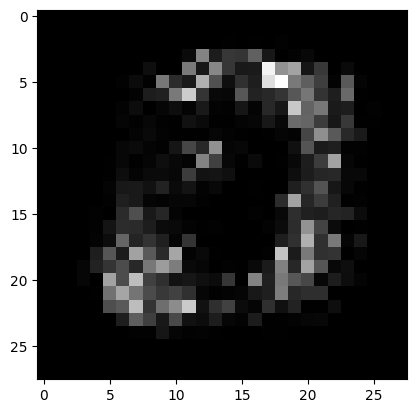

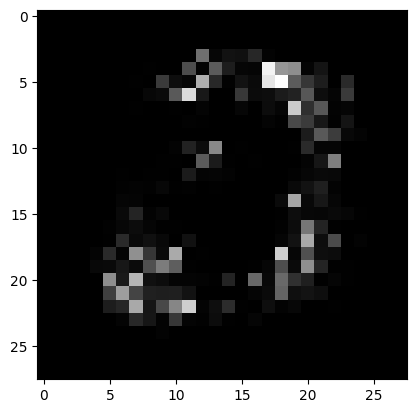

Epoch: 3550
loss_g: 0.9877902269363403 	loss_d: 0.8520612120628357
Epoch: 3600
loss_g: 1.0937790870666504 	loss_d: 0.7857436537742615
Epoch: 3650
loss_g: 1.2952370643615723 	loss_d: 0.5680701732635498
Epoch: 3700
loss_g: 1.2024184465408325 	loss_d: 0.7256051301956177
Epoch: 3750
loss_g: 1.3282592296600342 	loss_d: 0.9183799028396606
Epoch: 3800
loss_g: 1.482611060142517 	loss_d: 0.7425055503845215
Epoch: 3850
loss_g: 1.4454439878463745 	loss_d: 0.8741761445999146
Epoch: 3900
loss_g: 1.5819121599197388 	loss_d: 0.6265428066253662
Epoch: 3950
loss_g: 1.5366984605789185 	loss_d: 0.6769152879714966
Epoch: 4000
loss_g: 1.530741810798645 	loss_d: 0.6905614137649536


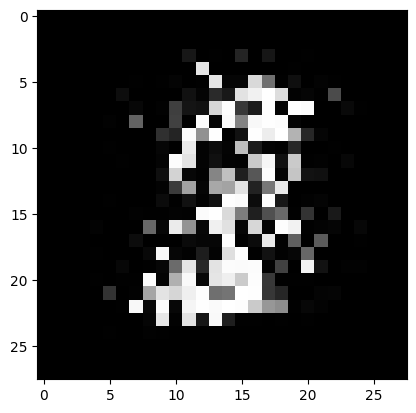

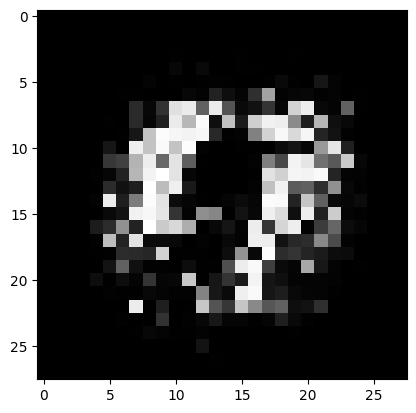

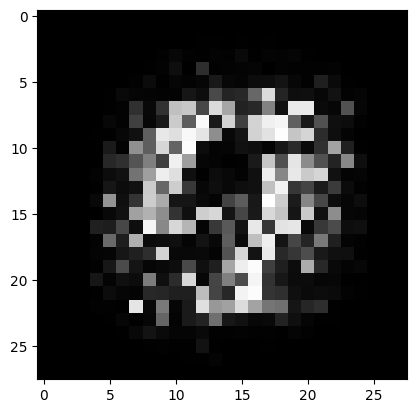

Epoch: 4050
loss_g: 1.5922846794128418 	loss_d: 0.6776106357574463
Epoch: 4100
loss_g: 1.8689672946929932 	loss_d: 0.7210049629211426
Epoch: 4150
loss_g: 1.6342397928237915 	loss_d: 0.7937760353088379
Epoch: 4200
loss_g: 1.9771959781646729 	loss_d: 0.48171454668045044
Epoch: 4250
loss_g: 1.796883463859558 	loss_d: 0.46508723497390747
Epoch: 4300
loss_g: 1.8781856298446655 	loss_d: 0.574299693107605
Epoch: 4350
loss_g: 2.247302532196045 	loss_d: 0.3222562074661255
Epoch: 4400
loss_g: 1.8150359392166138 	loss_d: 0.5439062118530273
Epoch: 4450
loss_g: 1.8253066539764404 	loss_d: 0.5201880931854248
Epoch: 4500
loss_g: 1.7043465375900269 	loss_d: 0.5852935910224915


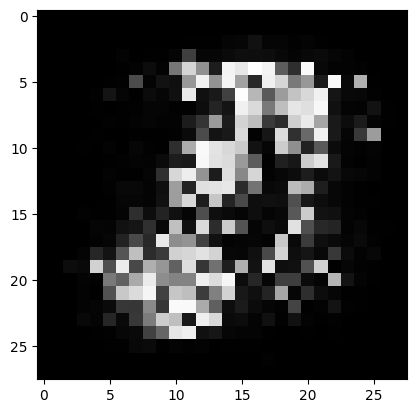

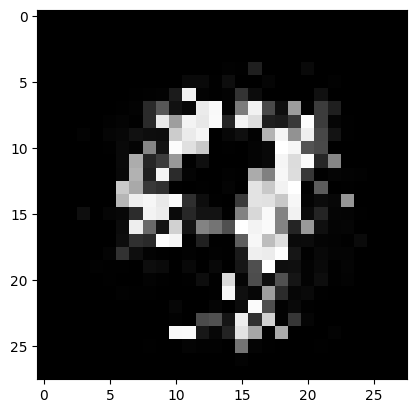

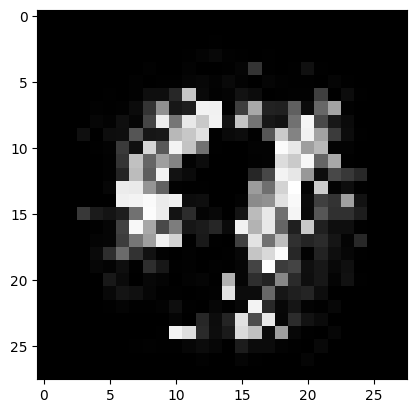

Epoch: 4550
loss_g: 1.791731834411621 	loss_d: 0.5078308582305908
Epoch: 4600
loss_g: 2.052522897720337 	loss_d: 0.39825624227523804
Epoch: 4650
loss_g: 1.682546615600586 	loss_d: 0.5711609721183777
Epoch: 4700
loss_g: 1.8040783405303955 	loss_d: 0.5666571855545044
Epoch: 4750
loss_g: 1.9645124673843384 	loss_d: 0.5334292650222778
Epoch: 4800
loss_g: 1.8428270816802979 	loss_d: 0.666793942451477
Epoch: 4850
loss_g: 2.3009612560272217 	loss_d: 0.28135257959365845
Epoch: 4900
loss_g: 2.3568339347839355 	loss_d: 0.5536561608314514
Epoch: 4950
loss_g: 2.1798360347747803 	loss_d: 0.47625815868377686
Epoch: 5000
loss_g: 1.7716816663742065 	loss_d: 0.6404882669448853


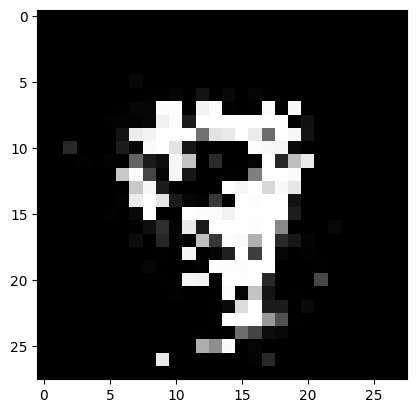

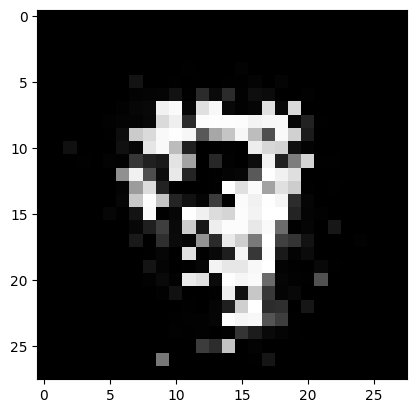

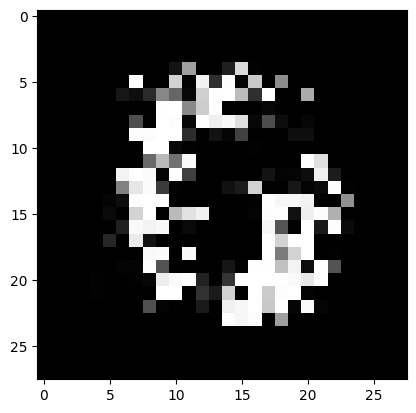

Epoch: 5050
loss_g: 1.8123289346694946 	loss_d: 0.634315013885498
Epoch: 5100
loss_g: 1.9085171222686768 	loss_d: 0.4524167776107788
Epoch: 5150
loss_g: 1.8026806116104126 	loss_d: 0.54267418384552
Epoch: 5200
loss_g: 1.773384690284729 	loss_d: 0.5303205251693726
Epoch: 5250
loss_g: 2.192589282989502 	loss_d: 0.5259652137756348
Epoch: 5300
loss_g: 2.228219747543335 	loss_d: 0.6419568061828613
Epoch: 5350
loss_g: 2.563976287841797 	loss_d: 0.4183741807937622
Epoch: 5400
loss_g: 1.8713308572769165 	loss_d: 0.5427060127258301
Epoch: 5450
loss_g: 2.021071434020996 	loss_d: 0.5635631084442139
Epoch: 5500
loss_g: 1.9397579431533813 	loss_d: 0.48590898513793945


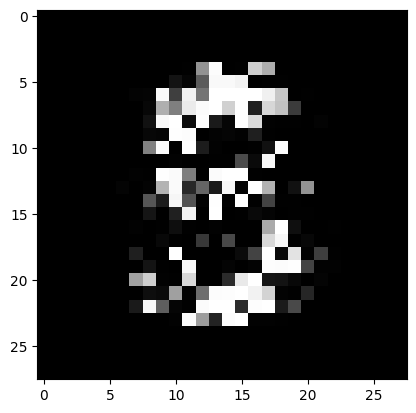

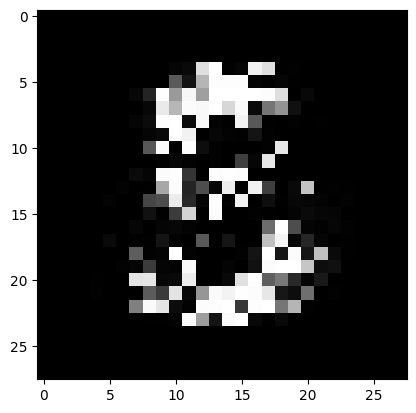

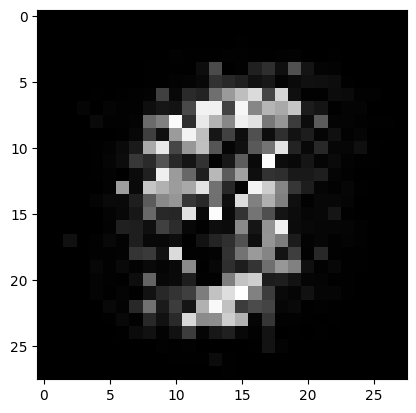

Epoch: 5550
loss_g: 1.9397414922714233 	loss_d: 0.536236584186554
Epoch: 5600
loss_g: 1.9529632329940796 	loss_d: 0.40227097272872925
Epoch: 5650
loss_g: 1.871150016784668 	loss_d: 0.4982491731643677
Epoch: 5700
loss_g: 2.046905279159546 	loss_d: 0.4905030429363251
Epoch: 5750
loss_g: 1.8988409042358398 	loss_d: 0.4059210419654846
Epoch: 5800
loss_g: 1.6115379333496094 	loss_d: 0.7190776467323303
Epoch: 5850
loss_g: 1.6374539136886597 	loss_d: 0.6676957607269287
Epoch: 5900
loss_g: 1.3592829704284668 	loss_d: 0.649673342704773
Epoch: 5950
loss_g: 1.6162182092666626 	loss_d: 0.5623735189437866
Epoch: 6000
loss_g: 1.6934242248535156 	loss_d: 0.5212482213973999


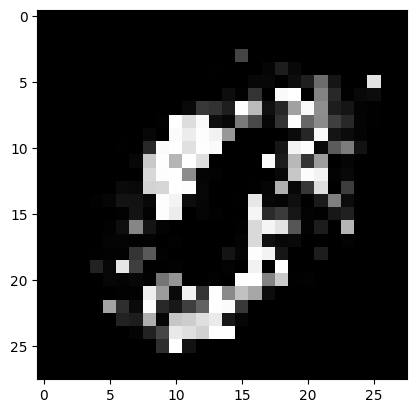

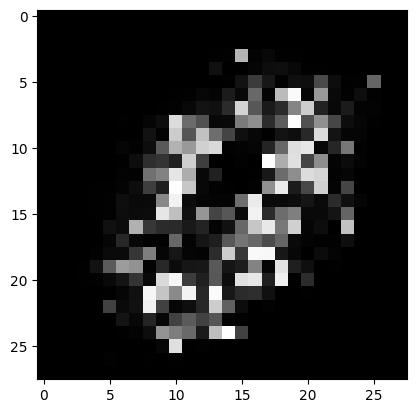

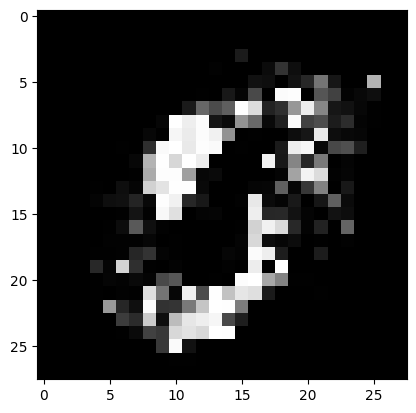

Epoch: 6050
loss_g: 1.38916015625 	loss_d: 0.7285366058349609
Epoch: 6100
loss_g: 1.6301952600479126 	loss_d: 0.6891766786575317
Epoch: 6150
loss_g: 1.475152850151062 	loss_d: 0.7511732578277588
Epoch: 6200
loss_g: 1.5452567338943481 	loss_d: 0.639132022857666
Epoch: 6250
loss_g: 1.578529953956604 	loss_d: 0.843303382396698
Epoch: 6300
loss_g: 1.5183007717132568 	loss_d: 0.6565775275230408
Epoch: 6350
loss_g: 1.7079949378967285 	loss_d: 0.5590725541114807
Epoch: 6400
loss_g: 1.610201358795166 	loss_d: 0.706001877784729
Epoch: 6450
loss_g: 1.4959509372711182 	loss_d: 0.8597700595855713
Epoch: 6500
loss_g: 1.678178071975708 	loss_d: 0.6978087425231934


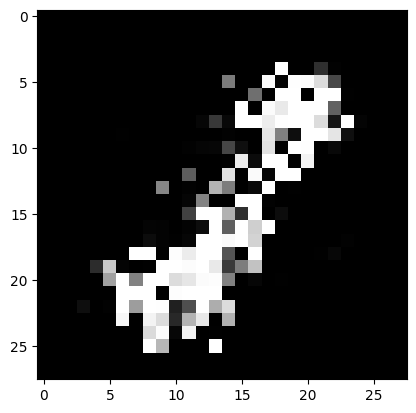

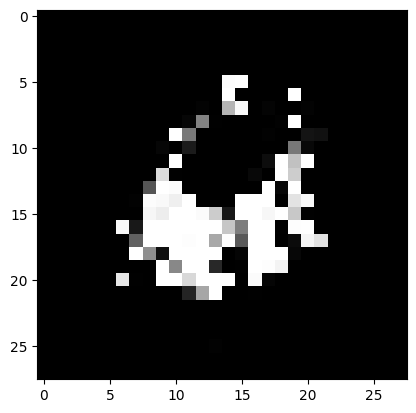

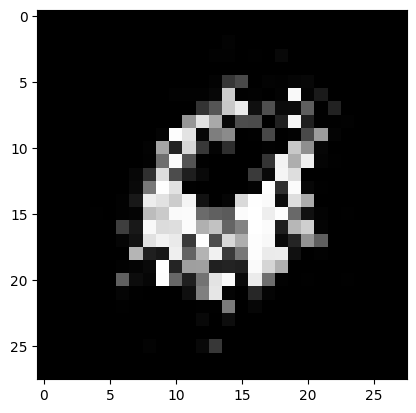

Epoch: 6550
loss_g: 1.6633471250534058 	loss_d: 0.764173150062561
Epoch: 6600
loss_g: 1.488904356956482 	loss_d: 0.808341383934021
Epoch: 6650
loss_g: 1.7747520208358765 	loss_d: 0.7409257888793945
Epoch: 6700
loss_g: 1.4220468997955322 	loss_d: 0.828080415725708
Epoch: 6750
loss_g: 1.7500442266464233 	loss_d: 0.7538959980010986
Epoch: 6800
loss_g: 1.515116810798645 	loss_d: 0.713295042514801
Epoch: 6850
loss_g: 1.5423409938812256 	loss_d: 0.7382185459136963
Epoch: 6900
loss_g: 1.627949833869934 	loss_d: 0.8607051968574524
Epoch: 6950
loss_g: 1.4744280576705933 	loss_d: 0.7695801258087158
Epoch: 7000
loss_g: 1.6136385202407837 	loss_d: 0.6124484539031982


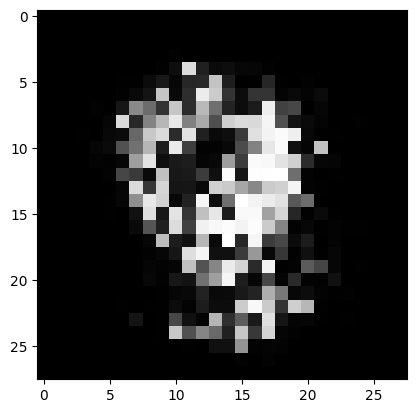

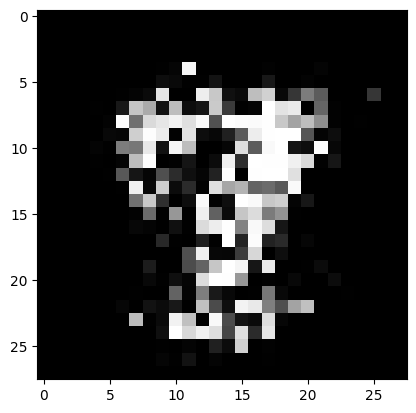

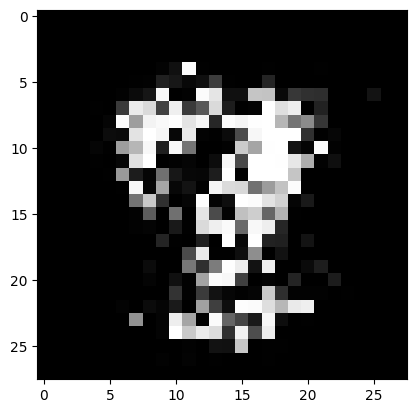

Epoch: 7050
loss_g: 1.7802170515060425 	loss_d: 0.6815099120140076
Epoch: 7100
loss_g: 1.5475518703460693 	loss_d: 0.7397375106811523
Epoch: 7150
loss_g: 1.4274128675460815 	loss_d: 0.9561610221862793
Epoch: 7200
loss_g: 1.4261199235916138 	loss_d: 0.7804588079452515
Epoch: 7250
loss_g: 1.7815922498703003 	loss_d: 0.639325737953186
Epoch: 7300
loss_g: 1.5671203136444092 	loss_d: 0.6618661284446716
Epoch: 7350
loss_g: 1.6385754346847534 	loss_d: 0.6827365159988403
Epoch: 7400
loss_g: 1.4143269062042236 	loss_d: 0.7309061288833618
Epoch: 7450
loss_g: 1.465471625328064 	loss_d: 0.7874987125396729
Epoch: 7500
loss_g: 1.4199930429458618 	loss_d: 0.7367222905158997


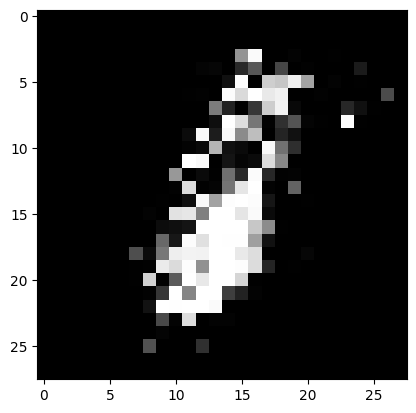

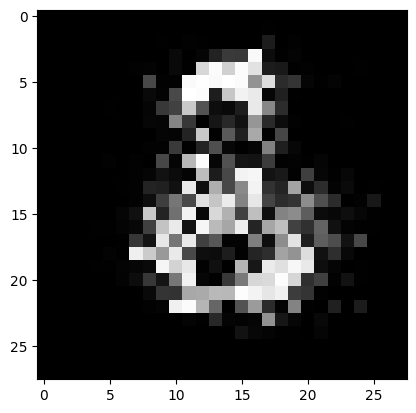

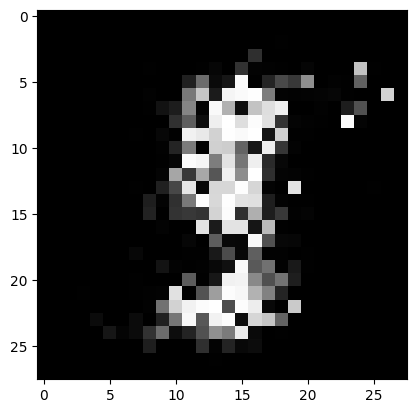

Epoch: 7550
loss_g: 1.3770180940628052 	loss_d: 0.8154523372650146
Epoch: 7600
loss_g: 1.2979040145874023 	loss_d: 0.8564022779464722
Epoch: 7650
loss_g: 1.5936285257339478 	loss_d: 0.7846875190734863
Epoch: 7700
loss_g: 1.3825008869171143 	loss_d: 0.9207525253295898
Epoch: 7750
loss_g: 1.4734188318252563 	loss_d: 0.7953413724899292
Epoch: 7800
loss_g: 1.4020601511001587 	loss_d: 0.8685004711151123
Epoch: 7850
loss_g: 1.6607786417007446 	loss_d: 0.7016031742095947
Epoch: 7900
loss_g: 1.6278756856918335 	loss_d: 0.7246112823486328
Epoch: 7950
loss_g: 1.5176241397857666 	loss_d: 0.6951429843902588
Epoch: 8000
loss_g: 1.6342850923538208 	loss_d: 0.7204589247703552


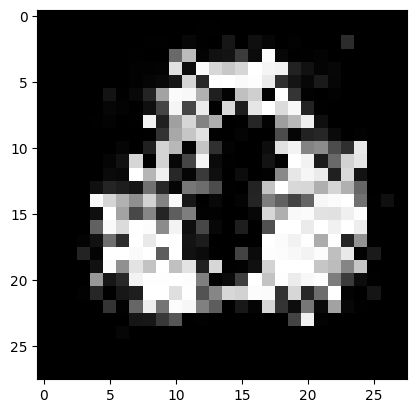

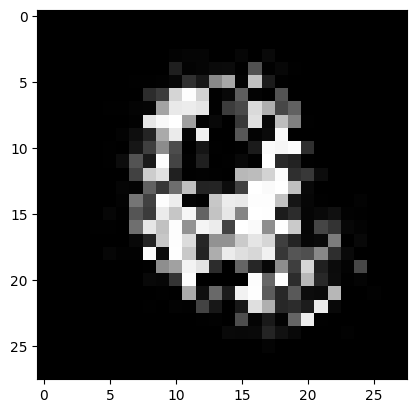

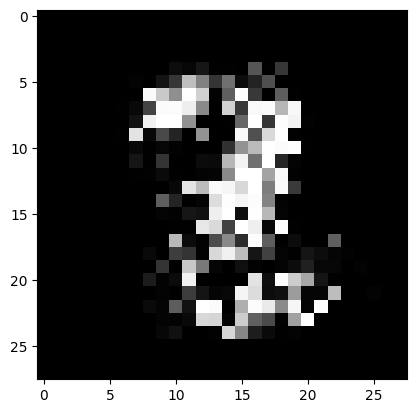

Epoch: 8050
loss_g: 1.5957494974136353 	loss_d: 0.5438545942306519
Epoch: 8100
loss_g: 1.6347030401229858 	loss_d: 0.7205804586410522
Epoch: 8150
loss_g: 1.3988218307495117 	loss_d: 0.8169538974761963
Epoch: 8200
loss_g: 1.3642611503601074 	loss_d: 0.9305020570755005
Epoch: 8250
loss_g: 1.7579373121261597 	loss_d: 0.5859262943267822
Epoch: 8300
loss_g: 1.604195475578308 	loss_d: 0.7172896862030029
Epoch: 8350
loss_g: 1.5420849323272705 	loss_d: 0.68602454662323
Epoch: 8400
loss_g: 1.724366545677185 	loss_d: 0.658344030380249
Epoch: 8450
loss_g: 1.62910795211792 	loss_d: 0.775488018989563
Epoch: 8500
loss_g: 1.5291097164154053 	loss_d: 0.8084304332733154


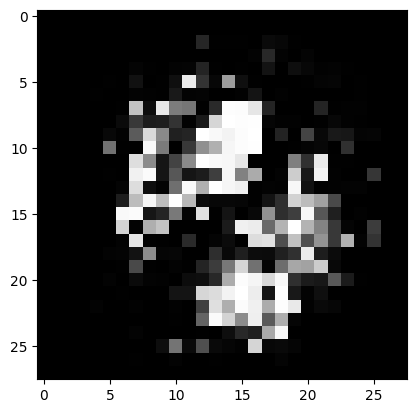

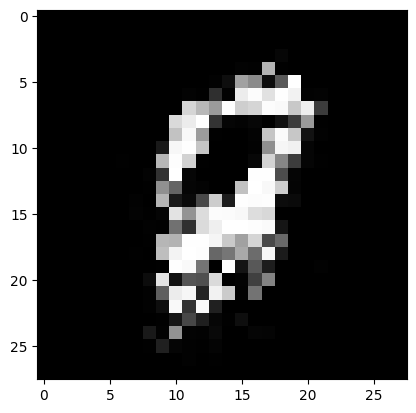

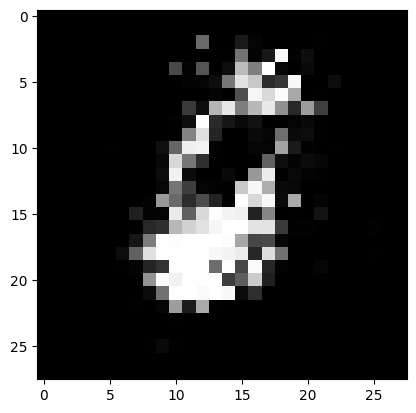

Epoch: 8550
loss_g: 1.568381905555725 	loss_d: 0.8436456918716431
Epoch: 8600
loss_g: 1.6171212196350098 	loss_d: 0.8532239198684692
Epoch: 8650
loss_g: 1.45579993724823 	loss_d: 1.1515616178512573
Epoch: 8700
loss_g: 1.5511826276779175 	loss_d: 0.7333616018295288
Epoch: 8750
loss_g: 1.4499096870422363 	loss_d: 0.8570123910903931
Epoch: 8800
loss_g: 1.3754969835281372 	loss_d: 0.7705079317092896
Epoch: 8850
loss_g: 1.4875370264053345 	loss_d: 0.7898951172828674
Epoch: 8900
loss_g: 1.4023491144180298 	loss_d: 0.7826399803161621
Epoch: 8950
loss_g: 1.5428414344787598 	loss_d: 0.6904740333557129
Epoch: 9000
loss_g: 1.6076486110687256 	loss_d: 0.7845637202262878


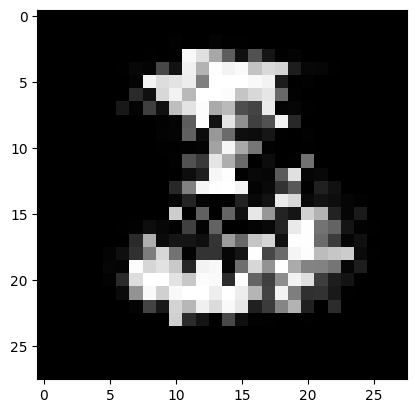

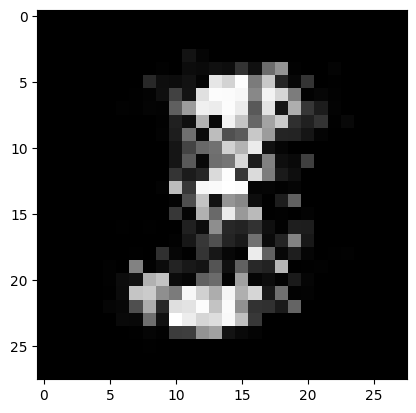

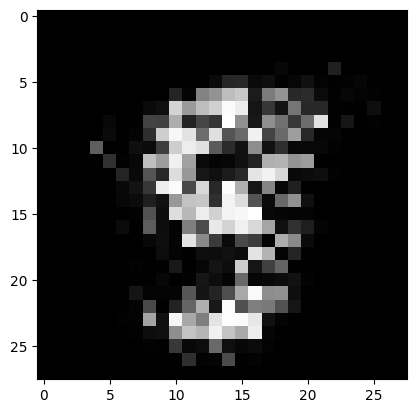

Epoch: 9050
loss_g: 1.3632264137268066 	loss_d: 0.9794119596481323
Epoch: 9100
loss_g: 1.2907710075378418 	loss_d: 0.8101387023925781
Epoch: 9150
loss_g: 1.4018064737319946 	loss_d: 0.8652436137199402
Epoch: 9200
loss_g: 1.41019868850708 	loss_d: 0.7873274087905884
Epoch: 9250
loss_g: 1.4483426809310913 	loss_d: 0.8159277439117432
Epoch: 9300
loss_g: 1.430440068244934 	loss_d: 0.8672348260879517
Epoch: 9350
loss_g: 1.4139859676361084 	loss_d: 0.8986343145370483
Epoch: 9400
loss_g: 1.3738797903060913 	loss_d: 0.9159412980079651
Epoch: 9450
loss_g: 1.2926135063171387 	loss_d: 0.8315964937210083
Epoch: 9500
loss_g: 1.3238271474838257 	loss_d: 1.0208537578582764


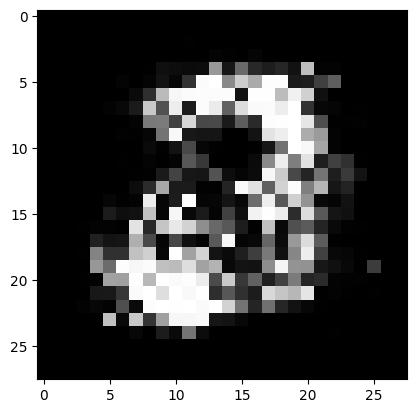

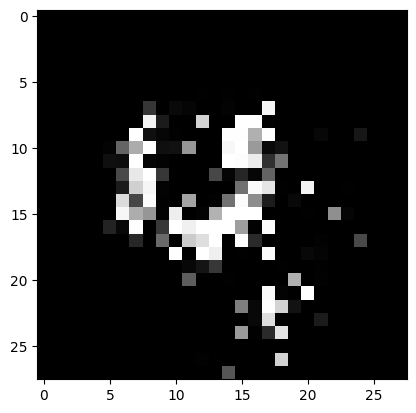

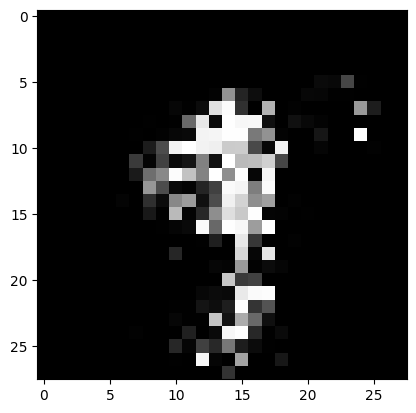

Epoch: 9550
loss_g: 1.1364843845367432 	loss_d: 1.0429707765579224
Epoch: 9600
loss_g: 1.3577276468276978 	loss_d: 0.9719764590263367
Epoch: 9650
loss_g: 1.3029918670654297 	loss_d: 0.929337739944458
Epoch: 9700
loss_g: 1.1994705200195312 	loss_d: 1.0926445722579956
Epoch: 9750
loss_g: 1.2066266536712646 	loss_d: 1.0907903909683228
Epoch: 9800
loss_g: 1.3357861042022705 	loss_d: 0.9591553807258606
Epoch: 9850
loss_g: 1.340186595916748 	loss_d: 0.9043881893157959
Epoch: 9900
loss_g: 1.2482388019561768 	loss_d: 1.0130460262298584
Epoch: 9950
loss_g: 1.3053250312805176 	loss_d: 0.821087658405304
Epoch: 10000
loss_g: 1.272812843322754 	loss_d: 0.8578897714614868


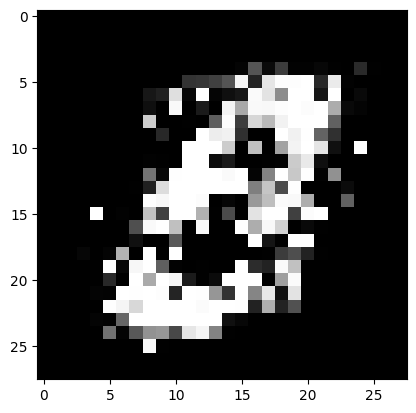

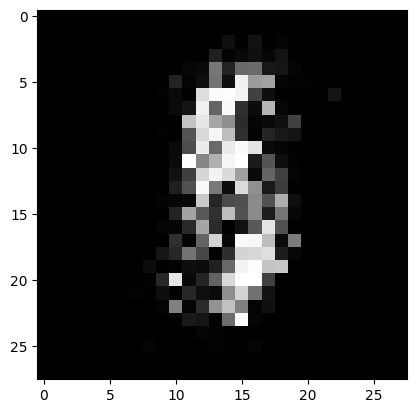

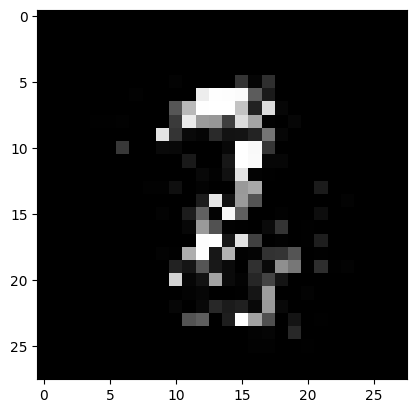

Epoch: 10050
loss_g: 1.1871501207351685 	loss_d: 1.042763352394104
Epoch: 10100
loss_g: 1.334094762802124 	loss_d: 0.80525803565979
Epoch: 10150
loss_g: 1.3203990459442139 	loss_d: 0.8552161455154419
Epoch: 10200
loss_g: 1.3278205394744873 	loss_d: 0.8157516121864319
Epoch: 10250
loss_g: 1.48722505569458 	loss_d: 0.949542760848999
Epoch: 10300
loss_g: 1.4252734184265137 	loss_d: 0.8052045106887817
Epoch: 10350
loss_g: 1.3425971269607544 	loss_d: 0.8344452381134033
Epoch: 10400
loss_g: 1.3542981147766113 	loss_d: 0.769418478012085
Epoch: 10450
loss_g: 1.2047650814056396 	loss_d: 1.0067811012268066
Epoch: 10500
loss_g: 1.3520230054855347 	loss_d: 0.7641303539276123


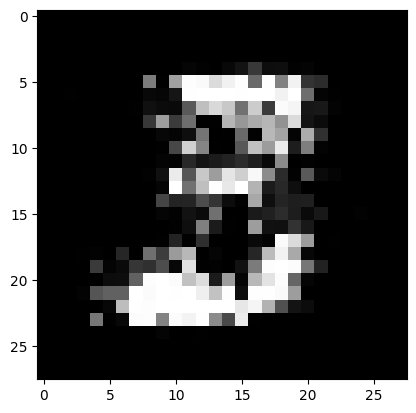

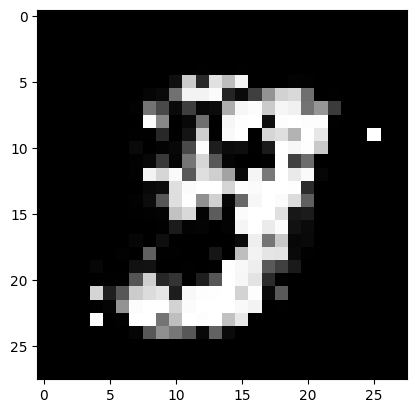

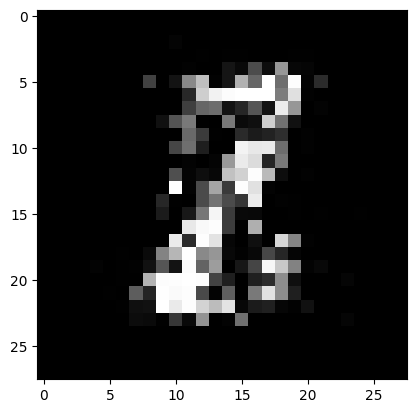

Epoch: 10550
loss_g: 1.4512346982955933 	loss_d: 0.6593811511993408
Epoch: 10600
loss_g: 1.4742591381072998 	loss_d: 0.7863046526908875
Epoch: 10650
loss_g: 1.2198206186294556 	loss_d: 0.9104350209236145
Epoch: 10700
loss_g: 1.4479857683181763 	loss_d: 0.7697985172271729
Epoch: 10750
loss_g: 1.3383721113204956 	loss_d: 0.879666805267334
Epoch: 10800
loss_g: 1.2948720455169678 	loss_d: 0.9092625379562378
Epoch: 10850
loss_g: 1.1843230724334717 	loss_d: 0.9785798788070679
Epoch: 10900
loss_g: 1.1321483850479126 	loss_d: 0.9982844591140747
Epoch: 10950
loss_g: 1.454857587814331 	loss_d: 0.8241091966629028
Epoch: 11000
loss_g: 1.438597559928894 	loss_d: 0.8789173364639282


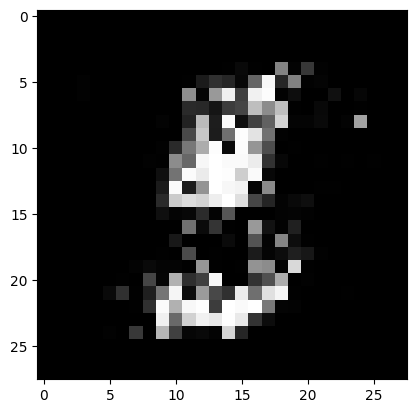

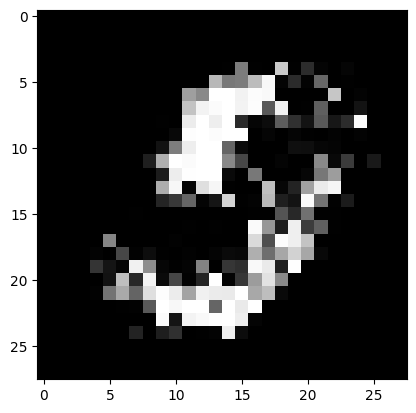

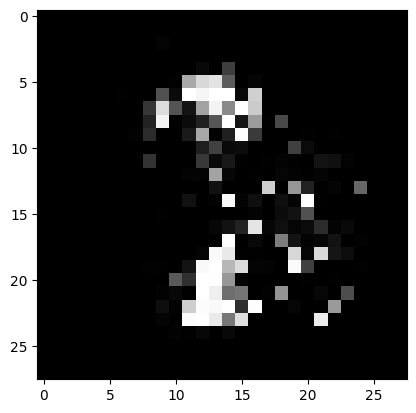

Epoch: 11050
loss_g: 1.3599352836608887 	loss_d: 1.099776268005371
Epoch: 11100
loss_g: 1.4956111907958984 	loss_d: 0.8187879323959351
Epoch: 11150
loss_g: 1.4411760568618774 	loss_d: 0.8295861482620239
Epoch: 11200
loss_g: 1.472554087638855 	loss_d: 0.9577509164810181
Epoch: 11250
loss_g: 1.6254048347473145 	loss_d: 0.7506577968597412
Epoch: 11300
loss_g: 1.3599145412445068 	loss_d: 0.8759257793426514
Epoch: 11350
loss_g: 1.2741938829421997 	loss_d: 0.9314899444580078
Epoch: 11400
loss_g: 1.380750060081482 	loss_d: 0.9179890155792236
Epoch: 11450
loss_g: 1.2755351066589355 	loss_d: 0.9688421487808228
Epoch: 11500
loss_g: 1.3158825635910034 	loss_d: 0.9003534317016602


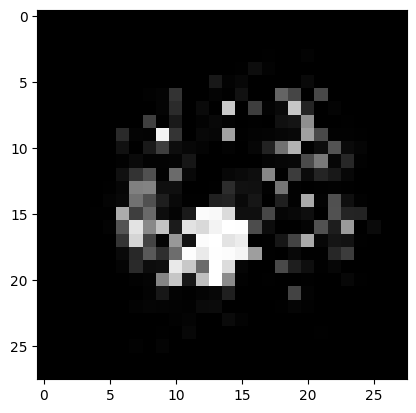

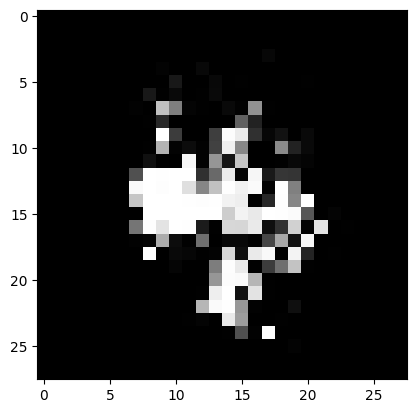

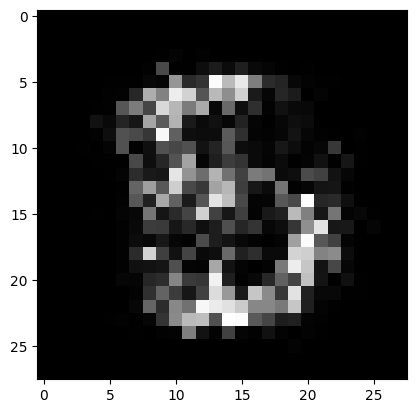

Epoch: 11550
loss_g: 1.3287792205810547 	loss_d: 0.8357973098754883
Epoch: 11600
loss_g: 1.3078449964523315 	loss_d: 1.1080063581466675
Epoch: 11650
loss_g: 1.4030390977859497 	loss_d: 0.9824435114860535
Epoch: 11700
loss_g: 1.3980971574783325 	loss_d: 0.9673317670822144
Epoch: 11750
loss_g: 1.4572362899780273 	loss_d: 0.9132251739501953
Epoch: 11800
loss_g: 1.4470070600509644 	loss_d: 0.9460726976394653
Epoch: 11850
loss_g: 1.3221511840820312 	loss_d: 1.0124895572662354
Epoch: 11900
loss_g: 1.1928445100784302 	loss_d: 1.1271171569824219
Epoch: 11950
loss_g: 1.1035908460617065 	loss_d: 1.2770366668701172
Epoch: 12000
loss_g: 1.2625319957733154 	loss_d: 0.9720978736877441


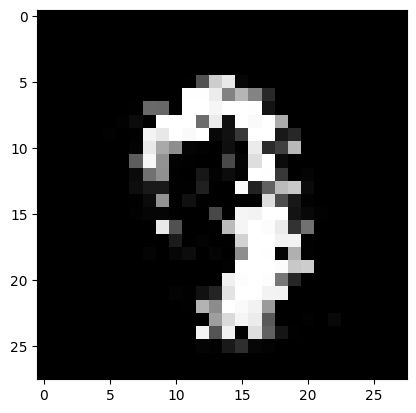

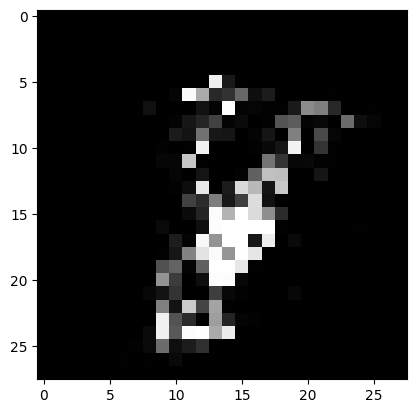

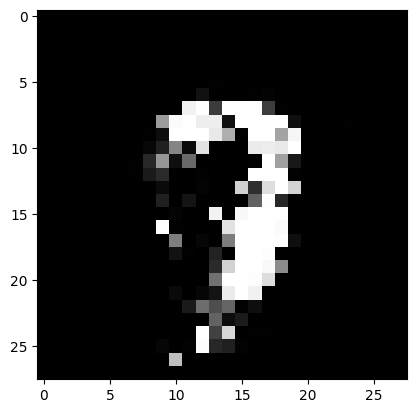

Epoch: 12050
loss_g: 1.1231350898742676 	loss_d: 1.0930118560791016
Epoch: 12100
loss_g: 1.29165780544281 	loss_d: 0.9321179389953613
Epoch: 12150
loss_g: 1.374194860458374 	loss_d: 0.9668897390365601
Epoch: 12200
loss_g: 1.4188625812530518 	loss_d: 0.9554684162139893
Epoch: 12250
loss_g: 1.6164278984069824 	loss_d: 0.8708661794662476
Epoch: 12300
loss_g: 1.3361703157424927 	loss_d: 1.0785017013549805
Epoch: 12350
loss_g: 1.4372880458831787 	loss_d: 0.9870034456253052
Epoch: 12400
loss_g: 1.5467828512191772 	loss_d: 0.8511906266212463
Epoch: 12450
loss_g: 1.4040066003799438 	loss_d: 0.9919338226318359
Epoch: 12500
loss_g: 1.2057855129241943 	loss_d: 1.231001615524292


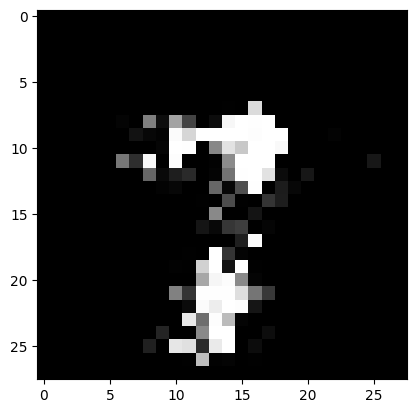

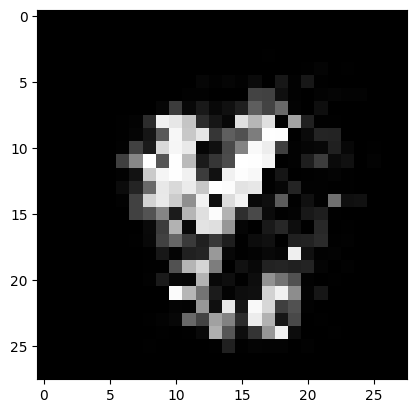

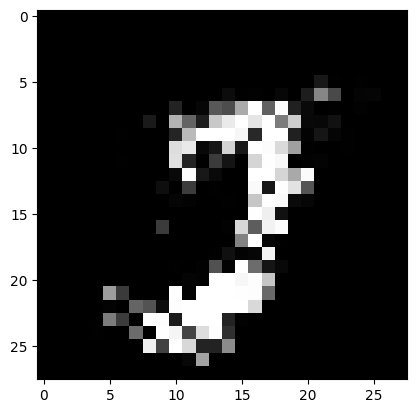

Epoch: 12550
loss_g: 1.2810534238815308 	loss_d: 1.1287248134613037
Epoch: 12600
loss_g: 1.385664939880371 	loss_d: 0.9356735944747925
Epoch: 12650
loss_g: 1.2962507009506226 	loss_d: 1.0894529819488525
Epoch: 12700
loss_g: 1.1660429239273071 	loss_d: 0.9156540632247925
Epoch: 12750
loss_g: 1.2916921377182007 	loss_d: 0.9599541425704956
Epoch: 12800
loss_g: 1.2426868677139282 	loss_d: 0.9768834114074707
Epoch: 12850
loss_g: 1.2958046197891235 	loss_d: 0.8904397487640381
Epoch: 12900
loss_g: 1.3297655582427979 	loss_d: 1.306008219718933
Epoch: 12950
loss_g: 1.437958002090454 	loss_d: 0.9931644201278687
Epoch: 13000
loss_g: 1.4197992086410522 	loss_d: 1.0818907022476196


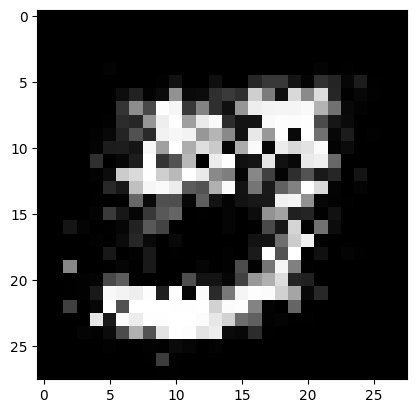

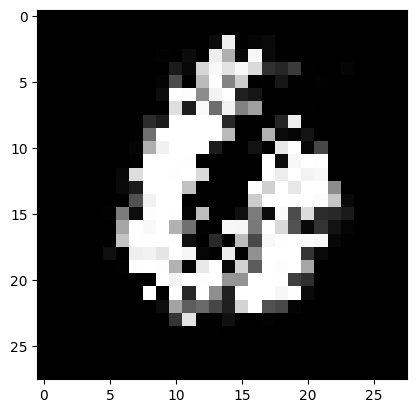

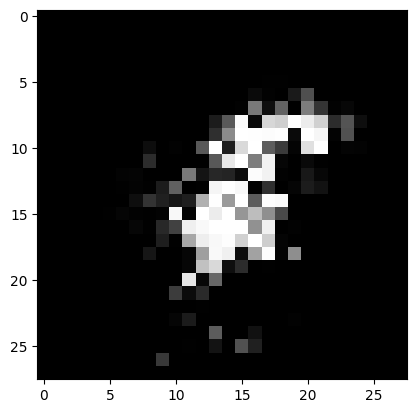

Epoch: 13050
loss_g: 1.5048296451568604 	loss_d: 0.8773900270462036
Epoch: 13100
loss_g: 1.4431982040405273 	loss_d: 0.9533290266990662
Epoch: 13150
loss_g: 1.3125057220458984 	loss_d: 1.0299992561340332
Epoch: 13200
loss_g: 1.1393280029296875 	loss_d: 1.443688154220581
Epoch: 13250
loss_g: 1.2416492700576782 	loss_d: 1.1975445747375488
Epoch: 13300
loss_g: 1.242546558380127 	loss_d: 1.0022403001785278
Epoch: 13350
loss_g: 1.2112919092178345 	loss_d: 0.9849491119384766
Epoch: 13400
loss_g: 1.6396923065185547 	loss_d: 0.8394778370857239
Epoch: 13450
loss_g: 1.3164358139038086 	loss_d: 0.8918125629425049
Epoch: 13500
loss_g: 1.161238193511963 	loss_d: 0.9861249327659607


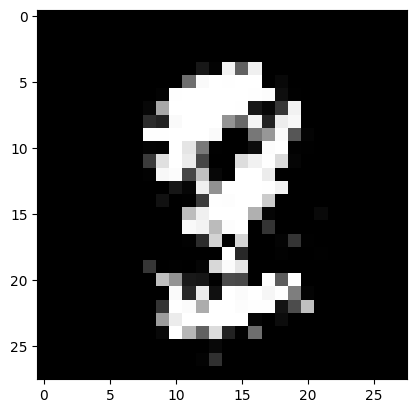

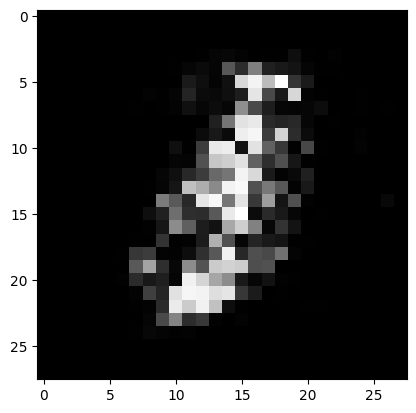

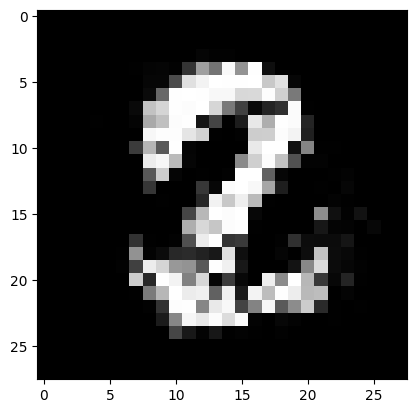

Epoch: 13550
loss_g: 1.291891098022461 	loss_d: 0.9691846370697021
Epoch: 13600
loss_g: 1.4325624704360962 	loss_d: 0.8732181787490845
Epoch: 13650
loss_g: 1.377624273300171 	loss_d: 0.7256684303283691
Epoch: 13700
loss_g: 1.3705708980560303 	loss_d: 0.8848577737808228
Epoch: 13750
loss_g: 1.111600637435913 	loss_d: 0.9716581106185913
Epoch: 13800
loss_g: 1.4092539548873901 	loss_d: 0.9089828133583069
Epoch: 13850
loss_g: 1.3681782484054565 	loss_d: 0.9364116191864014
Epoch: 13900
loss_g: 1.2539712190628052 	loss_d: 1.0122315883636475
Epoch: 13950
loss_g: 1.1342514753341675 	loss_d: 1.12384033203125
Epoch: 14000
loss_g: 1.4076380729675293 	loss_d: 0.9325599670410156


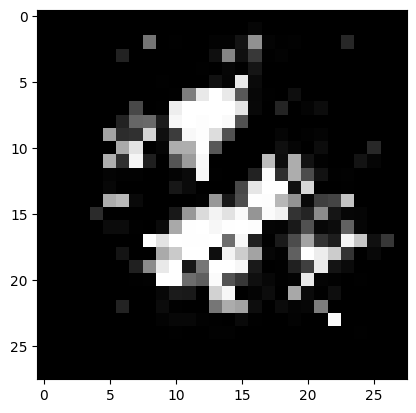

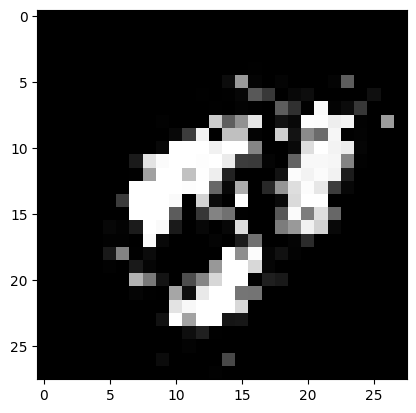

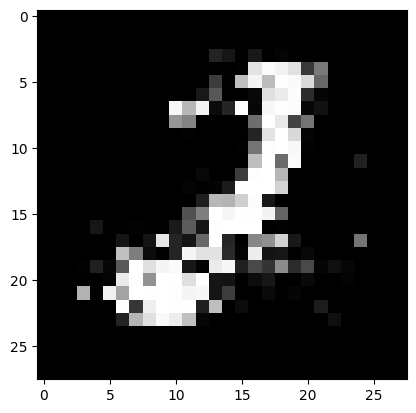

Epoch: 14050
loss_g: 1.1994941234588623 	loss_d: 1.0350866317749023
Epoch: 14100
loss_g: 1.3622405529022217 	loss_d: 0.8175512552261353
Epoch: 14150
loss_g: 1.3463060855865479 	loss_d: 0.9000756740570068
Epoch: 14200
loss_g: 1.1851216554641724 	loss_d: 1.1515028476715088
Epoch: 14250
loss_g: 1.203079342842102 	loss_d: 1.225090742111206
Epoch: 14300
loss_g: 1.1924703121185303 	loss_d: 1.141187310218811
Epoch: 14350
loss_g: 1.116729497909546 	loss_d: 1.1153117418289185
Epoch: 14400
loss_g: 1.2025185823440552 	loss_d: 1.316988229751587
Epoch: 14450
loss_g: 1.2390727996826172 	loss_d: 0.9867516756057739
Epoch: 14500
loss_g: 1.356325387954712 	loss_d: 1.099518060684204


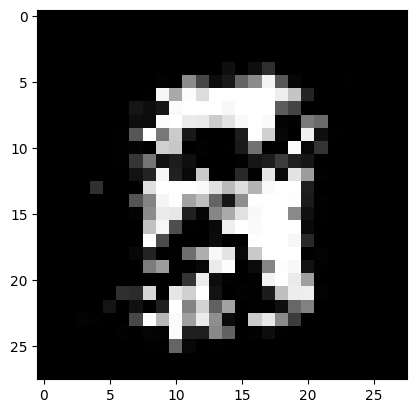

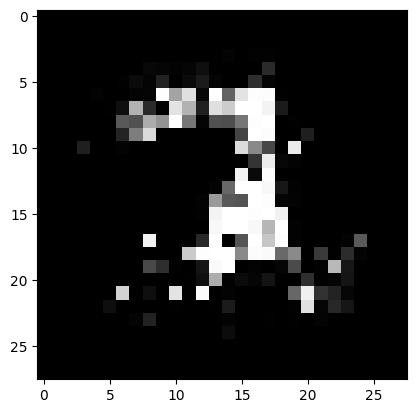

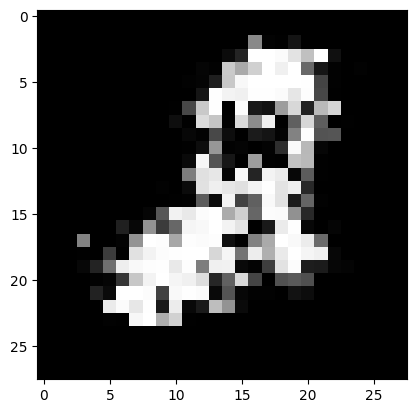

Epoch: 14550
loss_g: 1.2066162824630737 	loss_d: 0.9879913330078125
Epoch: 14600
loss_g: 1.0019158124923706 	loss_d: 1.2495427131652832
Epoch: 14650
loss_g: 1.245761752128601 	loss_d: 1.0745608806610107
Epoch: 14700
loss_g: 1.1383874416351318 	loss_d: 0.9646559953689575
Epoch: 14750
loss_g: 1.3030433654785156 	loss_d: 0.8889671564102173
Epoch: 14800
loss_g: 1.1041945219039917 	loss_d: 1.1586484909057617
Epoch: 14850
loss_g: 1.299133062362671 	loss_d: 0.8639907240867615
Epoch: 14900
loss_g: 1.2953139543533325 	loss_d: 0.8463481068611145
Epoch: 14950
loss_g: 1.3391491174697876 	loss_d: 0.9653525948524475
Epoch: 15000
loss_g: 1.460415005683899 	loss_d: 1.024526834487915


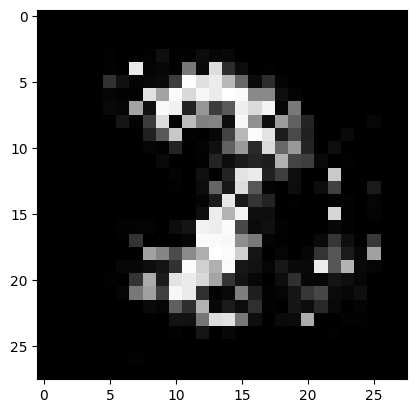

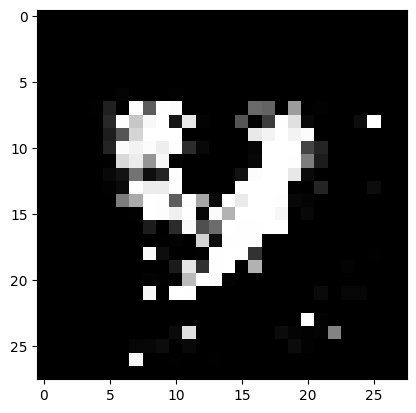

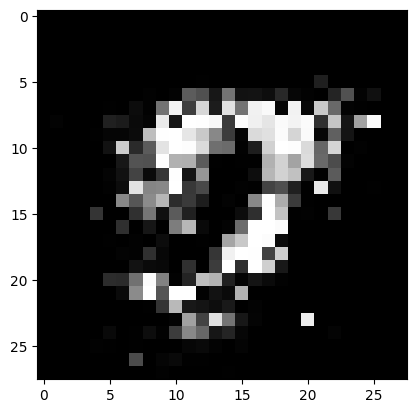

Epoch: 15050
loss_g: 1.2380329370498657 	loss_d: 0.9331929683685303
Epoch: 15100
loss_g: 1.2124890089035034 	loss_d: 1.1378576755523682
Epoch: 15150
loss_g: 1.2536405324935913 	loss_d: 0.9322063326835632
Epoch: 15200
loss_g: 1.454692006111145 	loss_d: 1.0705510377883911
Epoch: 15250
loss_g: 1.2981446981430054 	loss_d: 1.06748366355896
Epoch: 15300
loss_g: 1.3277260065078735 	loss_d: 1.0035345554351807
Epoch: 15350
loss_g: 1.2105220556259155 	loss_d: 1.1551847457885742
Epoch: 15400
loss_g: 1.3032188415527344 	loss_d: 0.9272559881210327
Epoch: 15450
loss_g: 1.4016010761260986 	loss_d: 1.0842678546905518
Epoch: 15500
loss_g: 1.0941134691238403 	loss_d: 1.0674796104431152


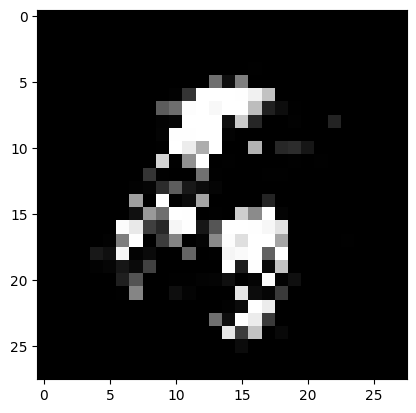

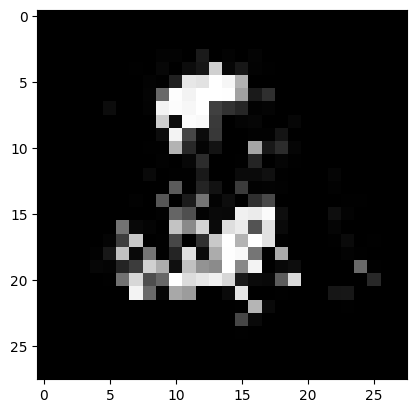

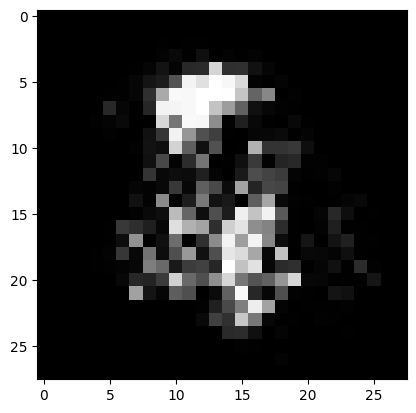

Epoch: 15550
loss_g: 1.2856907844543457 	loss_d: 1.1878397464752197
Epoch: 15600
loss_g: 1.066781997680664 	loss_d: 1.1305861473083496
Epoch: 15650
loss_g: 1.1975682973861694 	loss_d: 1.069483757019043
Epoch: 15700
loss_g: 1.2173879146575928 	loss_d: 1.0760082006454468
Epoch: 15750
loss_g: 1.1170978546142578 	loss_d: 1.025084137916565
Epoch: 15800
loss_g: 1.3558083772659302 	loss_d: 1.069616436958313
Epoch: 15850
loss_g: 1.1997151374816895 	loss_d: 1.0561449527740479
Epoch: 15900
loss_g: 1.2312872409820557 	loss_d: 1.0761654376983643
Epoch: 15950
loss_g: 1.0976687669754028 	loss_d: 1.0612587928771973
Epoch: 16000
loss_g: 1.2093100547790527 	loss_d: 1.0098025798797607


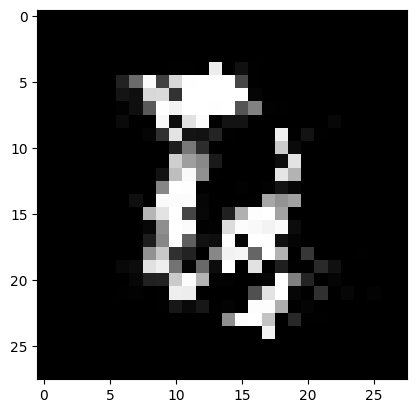

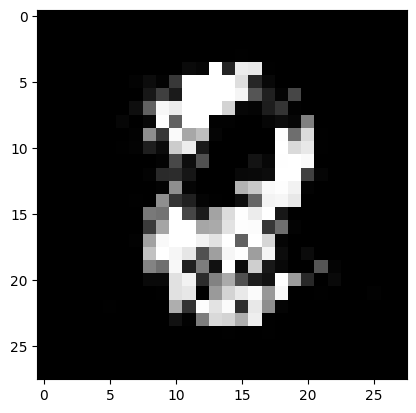

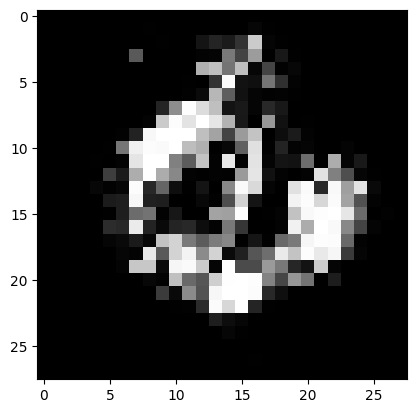

Epoch: 16050
loss_g: 1.0874216556549072 	loss_d: 1.0955348014831543
Epoch: 16100
loss_g: 1.1960413455963135 	loss_d: 1.0605334043502808
Epoch: 16150
loss_g: 1.3848447799682617 	loss_d: 1.0220654010772705
Epoch: 16200
loss_g: 1.2055598497390747 	loss_d: 1.0540192127227783
Epoch: 16250
loss_g: 1.1838948726654053 	loss_d: 1.1274863481521606
Epoch: 16300
loss_g: 1.1649250984191895 	loss_d: 1.100183129310608
Epoch: 16350
loss_g: 1.244963526725769 	loss_d: 0.9964593052864075
Epoch: 16400
loss_g: 1.2616026401519775 	loss_d: 1.0781323909759521
Epoch: 16450
loss_g: 1.4040724039077759 	loss_d: 0.8603519201278687
Epoch: 16500
loss_g: 1.2694913148880005 	loss_d: 0.9679150581359863


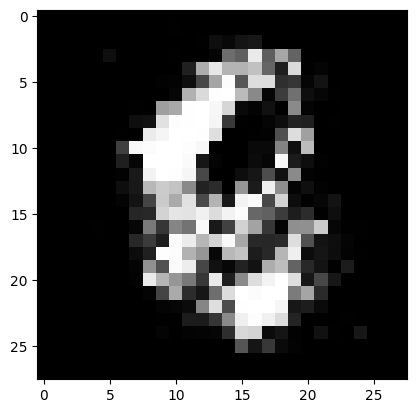

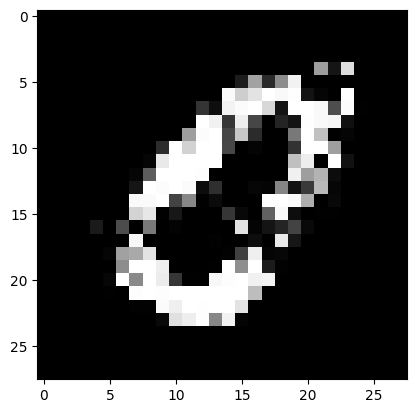

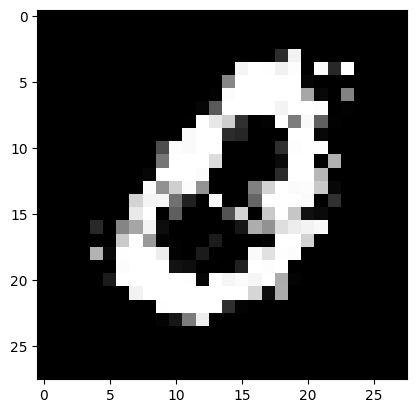

Epoch: 16550
loss_g: 1.2777700424194336 	loss_d: 1.1386754512786865
Epoch: 16600
loss_g: 1.2012851238250732 	loss_d: 1.0259556770324707
Epoch: 16650
loss_g: 1.1852726936340332 	loss_d: 1.0228341817855835
Epoch: 16700
loss_g: 1.2724136114120483 	loss_d: 0.9746236801147461
Epoch: 16750
loss_g: 1.1756130456924438 	loss_d: 0.9895734190940857
Epoch: 16800
loss_g: 1.2378199100494385 	loss_d: 0.9952797889709473
Epoch: 16850
loss_g: 1.332446575164795 	loss_d: 0.9884158372879028
Epoch: 16900
loss_g: 1.3292473554611206 	loss_d: 0.8465272188186646
Epoch: 16950
loss_g: 1.3456838130950928 	loss_d: 0.8406034708023071
Epoch: 17000
loss_g: 1.4421850442886353 	loss_d: 0.916335940361023


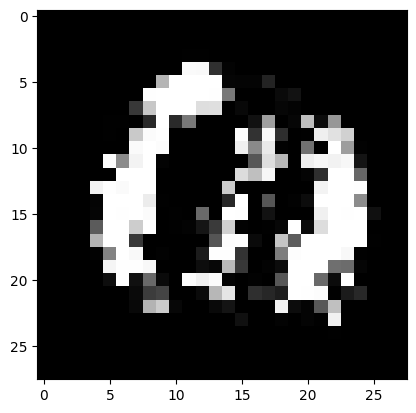

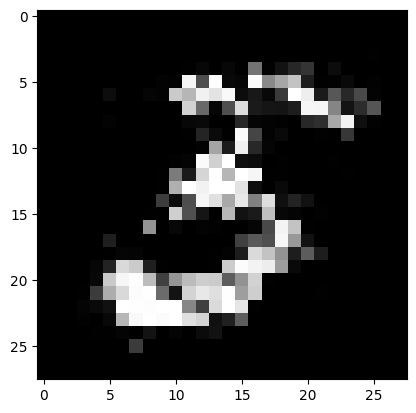

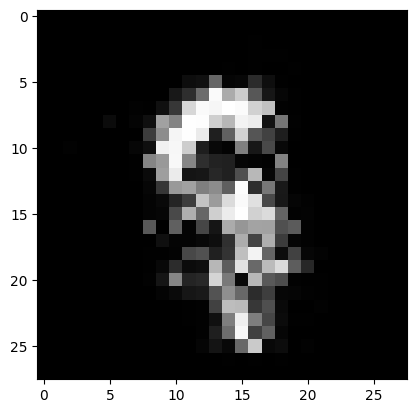

Epoch: 17050
loss_g: 1.3448998928070068 	loss_d: 1.035001516342163
Epoch: 17100
loss_g: 1.382440209388733 	loss_d: 0.9134095907211304
Epoch: 17150
loss_g: 1.384729027748108 	loss_d: 0.96799635887146
Epoch: 17200
loss_g: 1.302877426147461 	loss_d: 0.9696692228317261
Epoch: 17250
loss_g: 1.198243498802185 	loss_d: 1.2031842470169067
Epoch: 17300
loss_g: 1.2900820970535278 	loss_d: 1.0902156829833984
Epoch: 17350
loss_g: 1.3329881429672241 	loss_d: 0.9433940052986145
Epoch: 17400
loss_g: 1.2845467329025269 	loss_d: 1.1232590675354004
Epoch: 17450
loss_g: 1.2795357704162598 	loss_d: 1.0249167680740356
Epoch: 17500
loss_g: 1.2768797874450684 	loss_d: 1.197654128074646


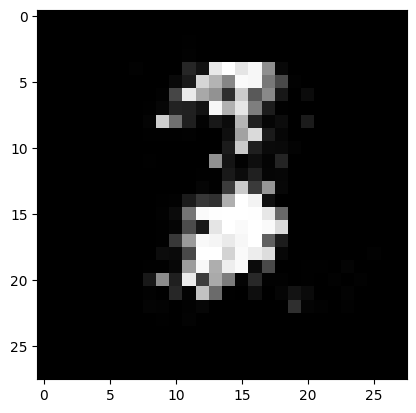

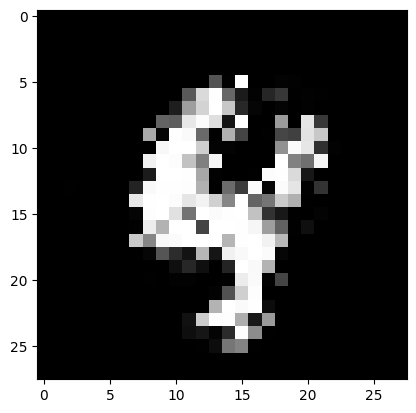

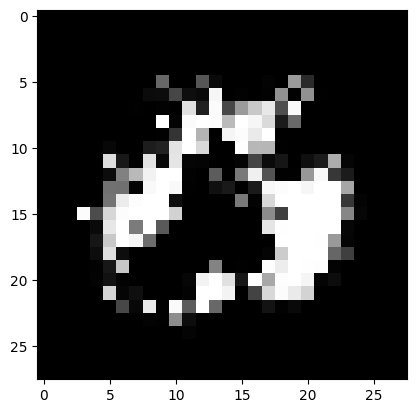

Epoch: 17550
loss_g: 1.245017409324646 	loss_d: 0.8903193473815918
Epoch: 17600
loss_g: 1.2068123817443848 	loss_d: 1.0092841386795044
Epoch: 17650
loss_g: 1.286155104637146 	loss_d: 0.9131964445114136
Epoch: 17700
loss_g: 1.5197499990463257 	loss_d: 1.008925437927246
Epoch: 17750
loss_g: 1.2552415132522583 	loss_d: 0.946030855178833
Epoch: 17800
loss_g: 1.2143887281417847 	loss_d: 1.0557938814163208
Epoch: 17850
loss_g: 1.3336024284362793 	loss_d: 1.0133635997772217
Epoch: 17900
loss_g: 1.2615406513214111 	loss_d: 0.8728456497192383
Epoch: 17950
loss_g: 1.5247204303741455 	loss_d: 0.886354923248291
Epoch: 18000
loss_g: 1.4560506343841553 	loss_d: 0.963279128074646


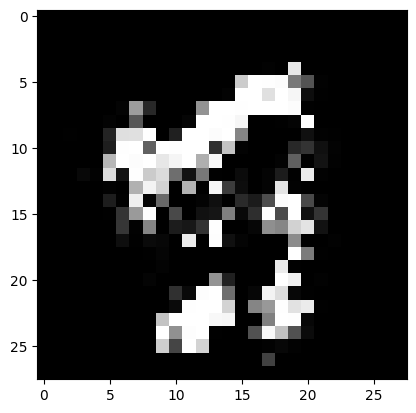

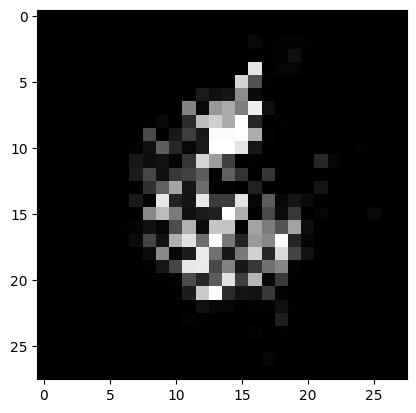

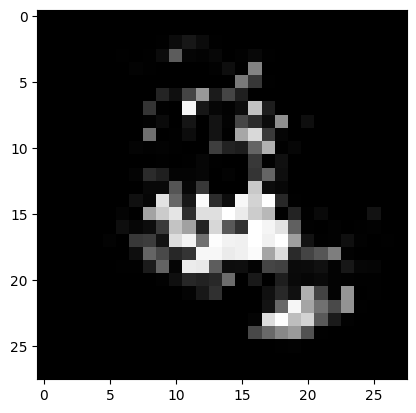

Epoch: 18050
loss_g: 1.298101782798767 	loss_d: 0.9500364065170288
Epoch: 18100
loss_g: 1.20063316822052 	loss_d: 1.088073968887329
Epoch: 18150
loss_g: 1.3123433589935303 	loss_d: 0.9433512091636658
Epoch: 18200
loss_g: 1.3385742902755737 	loss_d: 1.0512795448303223
Epoch: 18250
loss_g: 1.159170389175415 	loss_d: 1.2000269889831543
Epoch: 18300
loss_g: 1.2499754428863525 	loss_d: 1.0913337469100952
Epoch: 18350
loss_g: 1.301375150680542 	loss_d: 1.0529836416244507
Epoch: 18400
loss_g: 1.3765822649002075 	loss_d: 1.002147912979126
Epoch: 18450
loss_g: 1.3596493005752563 	loss_d: 1.0071392059326172
Epoch: 18500
loss_g: 1.4291127920150757 	loss_d: 0.9655001163482666


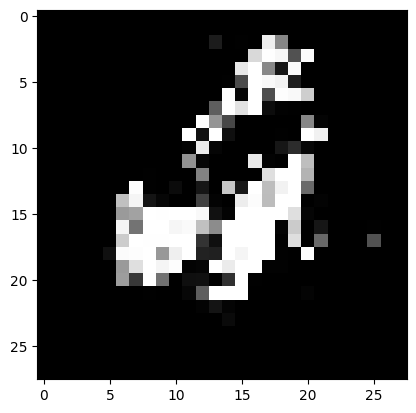

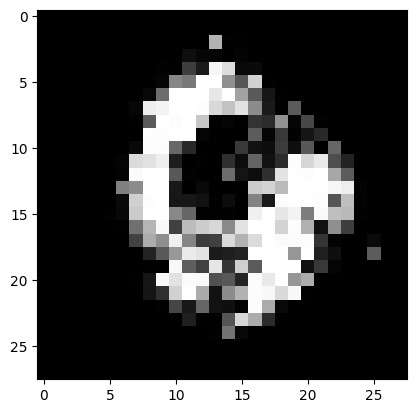

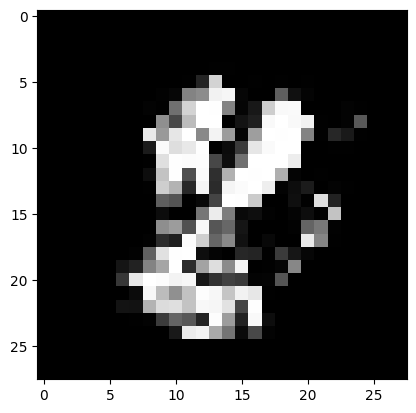

Epoch: 18550
loss_g: 1.3796554803848267 	loss_d: 0.9362767338752747
Epoch: 18600
loss_g: 1.419737696647644 	loss_d: 1.0330283641815186
Epoch: 18650
loss_g: 1.3030827045440674 	loss_d: 0.8946224451065063
Epoch: 18700
loss_g: 1.3274656534194946 	loss_d: 1.051987648010254
Epoch: 18750
loss_g: 1.283890962600708 	loss_d: 0.9238244295120239
Epoch: 18800
loss_g: 1.2469508647918701 	loss_d: 1.0566693544387817
Epoch: 18850
loss_g: 1.2980175018310547 	loss_d: 1.017427921295166
Epoch: 18900
loss_g: 1.234552025794983 	loss_d: 1.050950288772583
Epoch: 18950
loss_g: 1.2080812454223633 	loss_d: 0.9446291327476501
Epoch: 19000
loss_g: 1.3482427597045898 	loss_d: 1.09702730178833


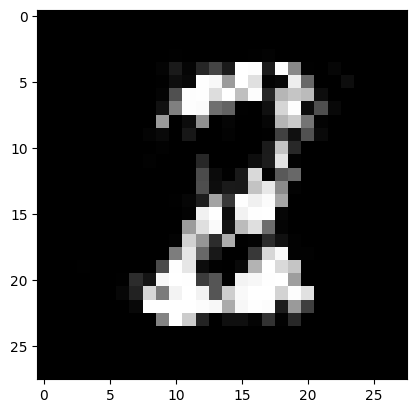

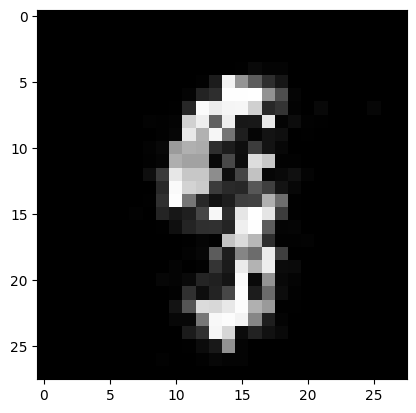

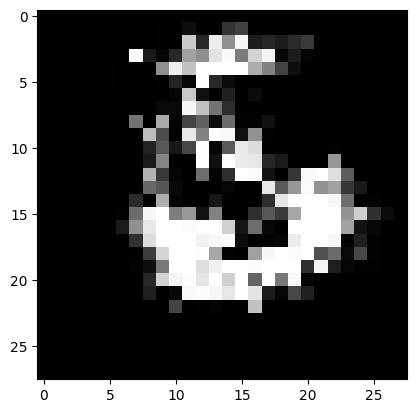

Epoch: 19050
loss_g: 1.2602709531784058 	loss_d: 1.0216906070709229
Epoch: 19100
loss_g: 1.143088936805725 	loss_d: 1.09531831741333
Epoch: 19150
loss_g: 1.198779582977295 	loss_d: 1.219139814376831
Epoch: 19200
loss_g: 1.2018895149230957 	loss_d: 1.002875566482544
Epoch: 19250
loss_g: 1.2000113725662231 	loss_d: 0.9384504556655884
Epoch: 19300
loss_g: 1.3692550659179688 	loss_d: 0.9224235415458679
Epoch: 19350
loss_g: 1.388383150100708 	loss_d: 1.023504376411438
Epoch: 19400
loss_g: 1.260841965675354 	loss_d: 1.106048345565796
Epoch: 19450
loss_g: 1.181823968887329 	loss_d: 1.1801291704177856
Epoch: 19500
loss_g: 1.2592999935150146 	loss_d: 0.9368906021118164


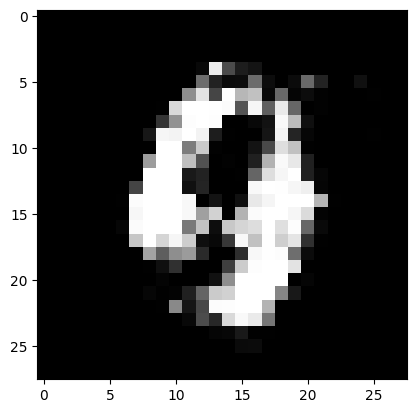

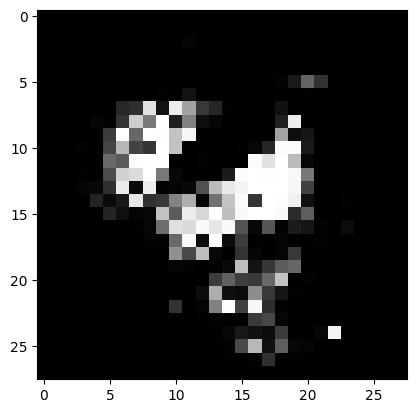

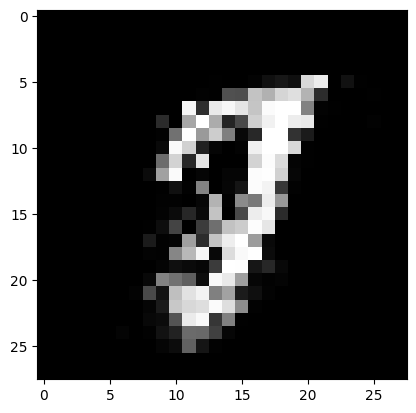

Epoch: 19550
loss_g: 1.445474624633789 	loss_d: 0.850645124912262
Epoch: 19600
loss_g: 1.3277915716171265 	loss_d: 1.067650318145752
Epoch: 19650
loss_g: 1.2877923250198364 	loss_d: 1.0233842134475708
Epoch: 19700
loss_g: 1.1444262266159058 	loss_d: 1.0594288110733032
Epoch: 19750
loss_g: 1.2709745168685913 	loss_d: 0.9547027349472046
Epoch: 19800
loss_g: 1.2114132642745972 	loss_d: 1.1134032011032104
Epoch: 19850
loss_g: 1.1681174039840698 	loss_d: 0.9925569295883179
Epoch: 19900
loss_g: 1.0573691129684448 	loss_d: 1.104057788848877
Epoch: 19950
loss_g: 1.231850266456604 	loss_d: 1.0946927070617676


In [5]:
lr = 0.0002
k = 1
epochs = 20000

generator = Generator().to(device)
disciminator = Discriminator().to(device)

optimizer_gen = torch.optim.Adam(generator.parameters(), lr=lr)
optimizer_dis = torch.optim.Adam(disciminator.parameters(), lr=lr)

criterion_gen = torch.nn.BCEWithLogitsLoss()
criterion_dis = torch.nn.BCEWithLogitsLoss()

train_models(disciminator, criterion_dis, optimizer_dis, generator, criterion_gen, optimizer_gen, epochs, train_loader, k, batch_size)

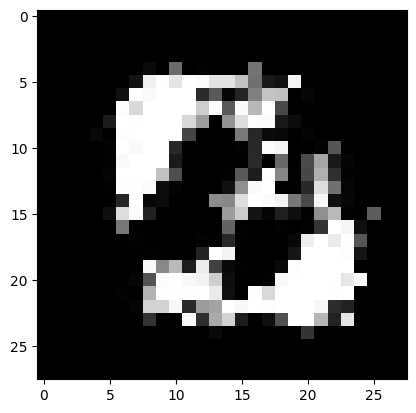

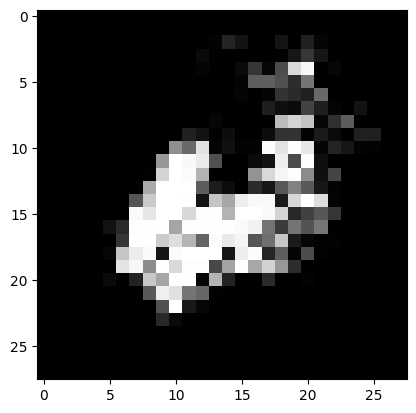

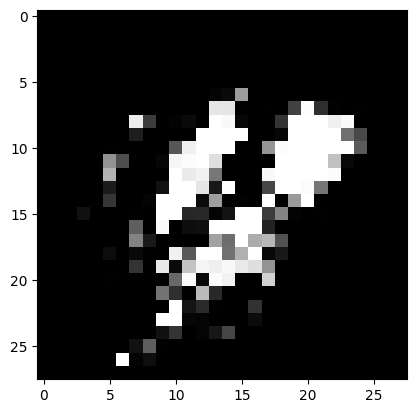

In [7]:
#Result
noise = torch.randn(5,100)
disp = generator(noise.to(device))
plot_digit(torch.reshape(disp[0,:],(28,28)).detach().cpu())
plot_digit(torch.reshape(disp[1,:],(28,28)).detach().cpu())
plot_digit(torch.reshape(disp[2,:],(28,28)).detach().cpu())